Используя базу "Аудиожанры", примените подход к музыке как к тексту и напишите сверточный классификатор (на базе слоя Conv1D) для подготовленных данных. Для этого:

1. Измените подготовку данных так, чтобы набор признаков, извлекаемый из аудиофайла, был представлен в виде последовательностей векторов признаков. Последовательности должны быть фиксированного размера и выбираться скользящим окном c заданным шагом. Другими словами: берем аудио-файл длительность, например, 30 сек. Берем отрезок фиксированной длины (например, 5с) и получаем набор признаков для этого отрезка. Смещаемся на шаг (например, 1с) и берем следующий отрезок. Таким образом готовим обучающую вборку.
2. Длину последовательности, размер шага и достаточный набор признаков определите самостоятельно исходя из требований к точности классификатора;
3. Разработайте классификатор на одномерных сверточных слоях **Conv1D** с точностью классификации жанра на тестовых данных не ниже **60%**, а на обучающих файлах - **68%** и выше;
4. Используйте за основу материал с урока, но при желании разработайте свои инструменты.

Импортируем необходимые библиотеки:

In [7]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, SpatialDropout1D

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Загрузим датасет в Colab:

In [8]:
# Загрузка датасета из облака
# gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip', None, quiet=True)

In [9]:
# Распаковка архива на локальный диск colab
# !unzip -qo genres.zip

# Проверка выгруженных папок
!ls genres

# Проверка содержимого одной папки
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [10]:
# Ваше решение
FILE_DIR = "./genres"  # Папка с файлами датасета
CLASS_LIST = os.listdir(FILE_DIR)  # Список классов, порядок меток не определен!
CLASS_LIST.sort()  # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)  # Количество классов
CLASS_FILES = 100  # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 90  # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1  # Доля проверочной выборки в основном наборе
DURATION_SEC = 30  # Анализируемая длительность аудиосигнала
N_FFT = 8192  # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512  # Объем данных для расчета одного набора признаков

SEQUENCE_DURATION_SEC = 3
SEQUENCE_OVERLAP_SEC = 1


In [11]:
FEATURE_VECTOR_SIZE = (
    12 + 20 + 1 + 1 + 1 + 1 + 1
)


SR = 22050
FRAMES_PER_SEQUENCE_SEGMENT = int(SR * SEQUENCE_DURATION_SEC / HOP_LENGTH)
FRAMES_PER_OVERLAP_STEP = int(SR * SEQUENCE_OVERLAP_SEC / HOP_LENGTH)


In [12]:
print(CLASS_LIST)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
def get_features(
    y,
    sr,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
):

    chroma_stft = librosa.feature.chroma_stft(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
    )
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    spec_cent = librosa.feature.spectral_centroid(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
    )
    spec_bw = librosa.feature.spectral_bandwidth(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
    )
    rolloff = librosa.feature.spectral_rolloff(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
    )
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)

    features = {
        "rmse": rmse,
        "spct": spec_cent,
        "spbw": spec_bw,
        "roff": rolloff,
        "zcr": zcr,
        "mfcc": mfcc,
        "stft": chroma_stft,
    }

    return features


In [14]:
def stack_features(feat):
    features = None

    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T


In [ ]:
def get_feature_list_from_file(
    class_index,  # индекс класса файла song_name
    song_name,  # имя аудиофайла
    duration_sec,  # длительность аудио в секундах
    sequence_duration_frames,
    overlap_frames,
):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    full_features = get_features(y, sr)
    stacked_full_features = stack_features(full_features)

    x_sequences = []
    y_labels = []

    # Перевод номера класса в one hot encoding
    y_label_one_hot = to_categorical(class_index, CLASS_COUNT)

    num_frames = stacked_full_features.shape[0]

    for i in range(0, num_frames - sequence_duration_frames + 1, overlap_frames):
        sequence = stacked_full_features[i : i + sequence_duration_frames]
        x_sequences.append(sequence)
        y_labels.append(y_label_one_hot)

    return np.array(x_sequences).astype("float32"), np.array(y_labels).astype("float32")


In [16]:
def process_file(
    class_index,  # индекс класса аудиофайла
    file_index,  # индекс (порядковый номер) аудиофайла в папке класса
    duration_sec,  # длительность аудио в секундах
    sequence_duration_frames,
    overlap_frames,
):
    class_name = CLASS_LIST[class_index]

    # Извлечение полного имени произведения
    song_name = f"{FILE_DIR}/{class_name}/{class_name}.{str(file_index).zfill(5)}.au"

    # Выборка признаков и метки класса для произведения в виде последовательностей
    file_x_sequences, file_y_labels = get_feature_list_from_file(
        class_index, song_name, duration_sec, sequence_duration_frames, overlap_frames
    )

    # Возврат имени файла и numpy-массивов последовательностей признаков и меток класса
    return song_name, file_x_sequences, file_y_labels


In [17]:
def extract_data(
    file_index_start,  # начальный индекс аудиофайла
    file_index_end,  # конечный индекс аудиофайла (не достигая)
    duration_sec=DURATION_SEC,  # длительность аудио в секундах
    sequence_duration_frames=FRAMES_PER_SEQUENCE_SEGMENT,
    overlap_frames=FRAMES_PER_OVERLAP_STEP,
):
    # Списки для последовательностей входных данных и меток класса
    x_data = []
    y_data = []

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in range(len(CLASS_LIST)):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_sequences, file_y_labels = process_file(
                class_index,
                file_index,
                duration_sec,
                sequence_duration_frames,
                overlap_frames,
            )
            x_data.extend(file_x_sequences)
            y_data.extend(file_y_labels)

        # Вывод информации о готовности обработки датасета
        print(
            f"Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c"
        )
        curr_time = time.time()

    # Возврат массивов набора данных
    return np.array(x_data), np.array(y_data)


In [18]:
print(
    "Формирование обучающего набора "
    f"данных ({FILE_INDEX_TRAIN_SPLIT} файлов на класс)..."
)
x_train_data, y_train_data = extract_data(0, FILE_INDEX_TRAIN_SPLIT)
print("Формирование обучающего набора данных завершено.")


Формирование обучающего набора данных (90 файлов на класс)...
Жанр blues готов -> 66 c
Жанр classical готов -> 66 c
Жанр country готов -> 68 c
Жанр disco готов -> 66 c
Жанр hiphop готов -> 66 c
Жанр jazz готов -> 70 c
Жанр metal готов -> 69 c
Жанр pop готов -> 67 c
Жанр reggae готов -> 70 c
Жанр rock готов -> 70 c
Формирование обучающего набора данных завершено.


In [19]:
original_shape = x_train_data.shape
x_train_data_reshaped = x_train_data.reshape(-1, original_shape[-1])
x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data_reshaped)
x_train_data_scaled = x_train_data_scaled.reshape(original_shape)

In [20]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train_data_scaled,
    y_train_data,
    stratify=y_train_data,
    test_size=VALIDATION_SPLIT,
    random_state=42,
)

print("Размер обучающей выборки X:", x_train.shape)
print("Размер обучающей выборки Y:", y_train.shape)
print("Размер валидационной выборки X:", x_val.shape)
print("Размер валидационной выборки Y:", y_val.shape)


Размер обучающей выборки X: (22680, 129, 37)
Размер обучающей выборки Y: (22680, 10)
Размер валидационной выборки X: (2520, 129, 37)
Размер валидационной выборки Y: (2520, 10)


In [21]:
def show_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle("График процесса обучения модели")
    ax1.plot(
        history.history["accuracy"], label="Доля верных ответов на обучающем наборе"
    )
    ax1.plot(
        history.history["val_accuracy"],
        label="Доля верных ответов на проверочном наборе",
    )
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel("Эпоха обучения")
    ax1.set_ylabel("Доля верных ответов")
    ax1.legend()

    ax2.plot(history.history["loss"], label="Ошибка на обучающем наборе")
    ax2.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel("Эпоха обучения")
    ax2.set_ylabel("Ошибка")
    ax2.legend()
    plt.show()


In [22]:
def classify_file(
    model,  # обученная модель классификатора
    x_scaler,  # настроенный нормировщик входных данных
    class_index,  # верный индекс класса аудиофайла
    file_index,  # индекс (порядковый номер) аудиофайла в папке
    duration_sec=DURATION_SEC,
    sequence_duration_frames=FRAMES_PER_SEQUENCE_SEGMENT,
    overlap_frames=FRAMES_PER_OVERLAP_STEP,
):
    # Подготовка выборки данных файла произведения в виде последовательностей
    song_name, file_x_sequences, file_y_data = process_file(
        class_index, file_index, duration_sec, sequence_duration_frames, overlap_frames
    )

    original_file_shape = file_x_sequences.shape
    file_x_sequences_reshaped = file_x_sequences.reshape(-1, original_file_shape[-1])
    file_x_sequences_scaled = x_scaler.transform(file_x_sequences_reshaped)
    file_x_sequences_scaled = file_x_sequences_scaled.reshape(original_file_shape)

    print("Файл:", song_name)
    print(
        "Количество последовательностей для предсказания:",
        file_x_sequences_scaled.shape[0],
    )


    predict = model.predict(file_x_sequences_scaled, verbose=0)

    predict_mean = predict.mean(axis=0)

    predict_class_index = np.argmax(predict_mean)

    predict_good = predict_class_index == class_index

    # Визуализация предсказания сети для файла
    plt.figure(figsize=(10, 3))
    print(
        "Классификация сети:",
        CLASS_LIST[predict_class_index],
        "-",
        "ВЕРНО :-)" if predict_good else "НЕВЕРНО.",
    )
    plt.title("Среднее распределение предсказаний по последовательностям")
    plt.bar(CLASS_LIST, predict_mean, color="g" if predict_good else "r")
    plt.show()
    print("---------------------------------------------------------------")

    # Возврат результата предсказания
    return predict_class_index


In [23]:
def classify_test_files(
    model,  # обученная модель классификатора
    x_scaler,  # настроенный нормировщик входных данных
    from_index,  # индекс аудиофайла, с которого начинать визуализацию
    n_files,  # количество файлов для визуализации
    duration_sec=DURATION_SEC,
    sequence_duration_frames=FRAMES_PER_SEQUENCE_SEGMENT,
    overlap_frames=FRAMES_PER_OVERLAP_STEP,
):
    predict_all = 0
    predict_good = 0
    y_true = []
    y_pred = []

    # Классификация каждого файла и аккумуляция результатов классификации
    for class_index in range(CLASS_COUNT):
        for file_index in range(from_index, from_index + n_files):
            predict_class_index = classify_file(
                model,
                x_scaler,
                class_index,
                file_index,
                duration_sec,
                sequence_duration_frames,
                overlap_frames,
            )
            y_true.append(class_index)
            y_pred.append(predict_class_index)
            predict_all += 1
            predict_good += predict_class_index == class_index

    # Расчет и вывод итогов классификации
    good_ratio = round(predict_good / predict_all * 100.0, 2)
    print(
        f"=== Обработано образцов: {predict_all}, из них распознано верно: {predict_good}, доля верных: {good_ratio}% ==="
    )

    # Построение матрицы ошибок без нормализации, покажет попадания в штуках
    cm = confusion_matrix(y_true, y_pred)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Матрица ошибок по файлам аудио (не нормализованная)")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()


In [24]:
print("Форма x_train:", x_train.shape)
print("Форма y_train:", y_train.shape)
print("Форма x_val:", x_val.shape)
print("Форма y_val:", y_val.shape)

Форма x_train: (22680, 129, 37)
Форма y_train: (22680, 10)
Форма x_val: (2520, 129, 37)
Форма y_val: (2520, 10)


In [25]:
model = Sequential(
    [
        Conv1D(
            filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(x_train.shape[1], x_train.shape[2]),
        ),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=128, kernel_size=3, activation="relu"),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=256, kernel_size=3, activation="relu"),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),

        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(CLASS_COUNT, activation="softmax"),
    ]
)


I0000 00:00:1748007207.784272    2376 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [26]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 127, 64)        │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 28, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       458,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,394 (2.26 MB)

 Trainable params: 591,498 (2.26 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100


I0000 00:00:1748007212.390653    8078 service.cc:148] XLA service 0x7f0d8c011da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748007212.391460    8078 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
I0000 00:00:1748007212.785463    8078 cuda_dnn.cc:529] Loaded cuDNN version 90300


 33/709 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1274 - loss: 3.8462

I0000 00:00:1748007217.234650    8078 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


709/709 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.2731 - loss: 2.4232 - val_accuracy: 0.4444 - val_loss: 2.0307
Epoch 2/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4765 - loss: 1.4659 - val_accuracy: 0.5206 - val_loss: 1.9301
Epoch 3/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5650 - loss: 1.2349 - val_accuracy: 0.5607 - val_loss: 1.8546
Epoch 4/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6144 - loss: 1.0874 - val_accuracy: 0.5960 - val_loss: 1.7649
Epoch 5/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6553 - loss: 0.9622 - val_accuracy: 0.6302 - val_loss: 1.5653
Epoch 6/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6858 - loss: 0.8824 - val_accuracy: 0.6440 - val_loss: 1.5444
Epoch 7/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7188 - loss: 0.8012 - val_accuracy: 0.6635 - val_loss: 1.4377
Epoch 8/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7412 - loss: 0.7203 - val_accuracy: 0.67

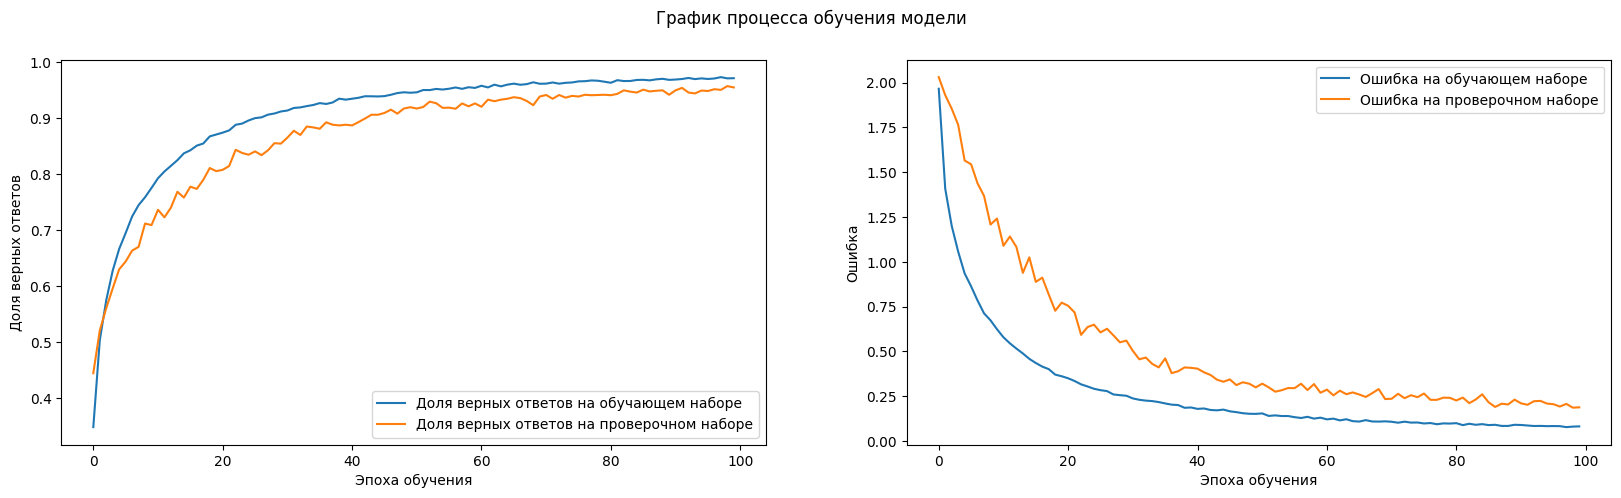

In [27]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1,
)

show_history(history)


Файл: ./genres/blues/blues.00090.au
Количество последовательностей для предсказания: 28
Классификация сети: blues - ВЕРНО :-)


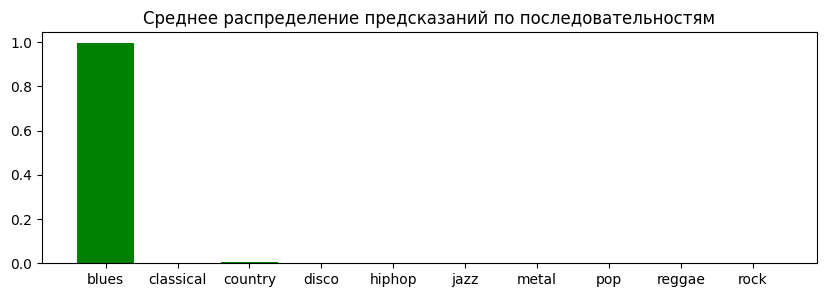

---------------------------------------------------------------
Файл: ./genres/blues/blues.00091.au
Количество последовательностей для предсказания: 28
Классификация сети: blues - ВЕРНО :-)


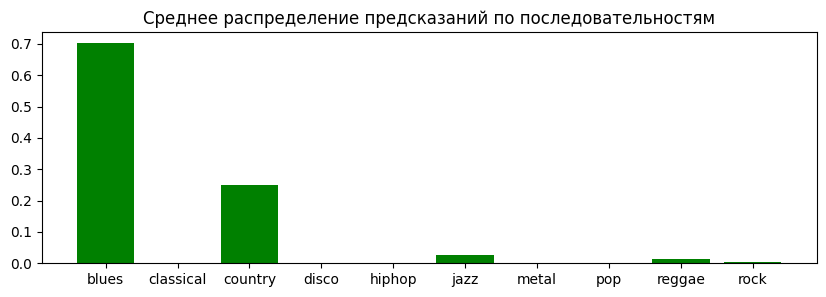

---------------------------------------------------------------
Файл: ./genres/blues/blues.00092.au
Количество последовательностей для предсказания: 28
Классификация сети: blues - ВЕРНО :-)


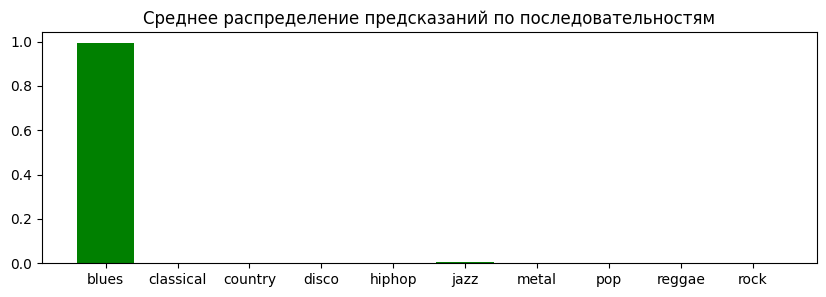

---------------------------------------------------------------
Файл: ./genres/blues/blues.00093.au
Количество последовательностей для предсказания: 28
Классификация сети: blues - ВЕРНО :-)


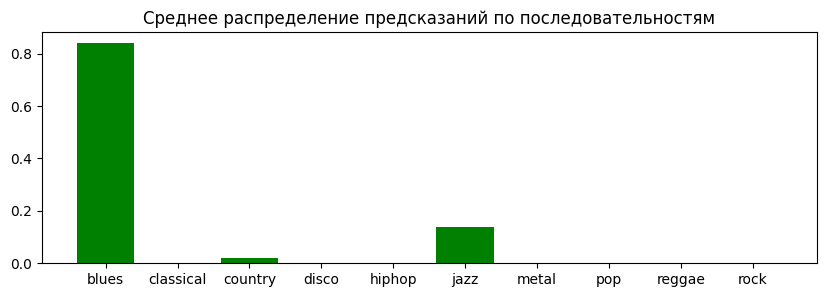

---------------------------------------------------------------
Файл: ./genres/blues/blues.00094.au
Количество последовательностей для предсказания: 28
Классификация сети: blues - ВЕРНО :-)


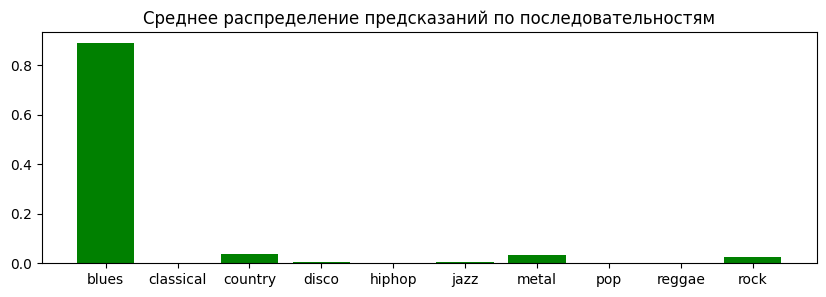

---------------------------------------------------------------
Файл: ./genres/blues/blues.00095.au
Количество последовательностей для предсказания: 28
Классификация сети: blues - ВЕРНО :-)


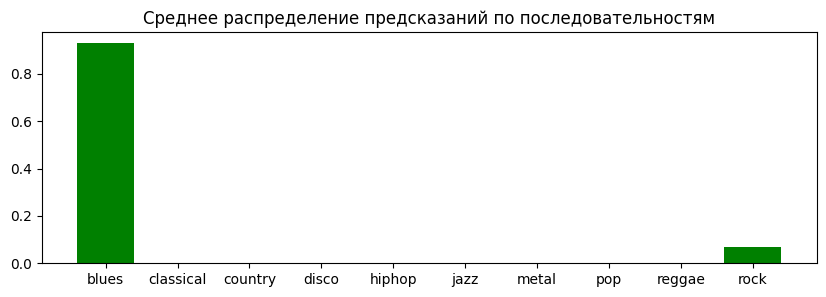

---------------------------------------------------------------
Файл: ./genres/blues/blues.00096.au
Количество последовательностей для предсказания: 28
Классификация сети: country - НЕВЕРНО.


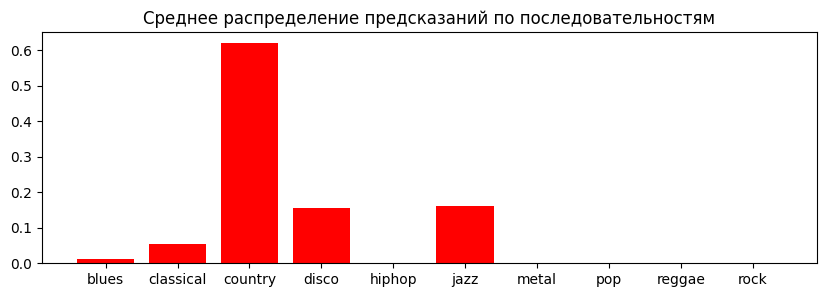

---------------------------------------------------------------
Файл: ./genres/blues/blues.00097.au
Количество последовательностей для предсказания: 28
Классификация сети: blues - ВЕРНО :-)


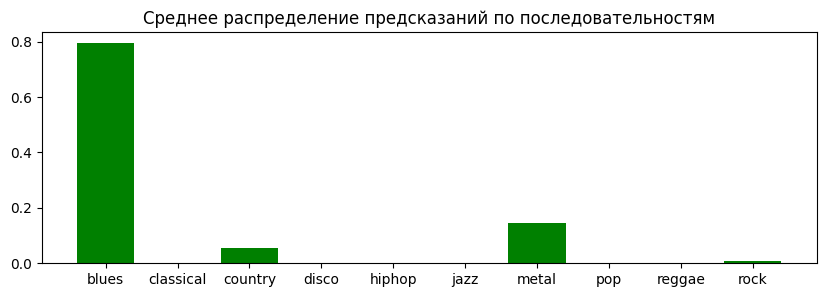

---------------------------------------------------------------
Файл: ./genres/blues/blues.00098.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


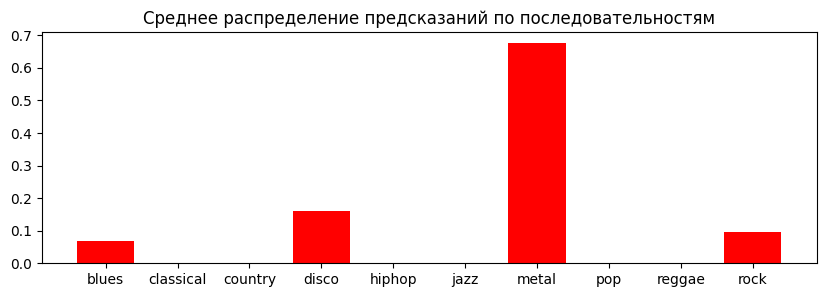

---------------------------------------------------------------
Файл: ./genres/blues/blues.00099.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - НЕВЕРНО.


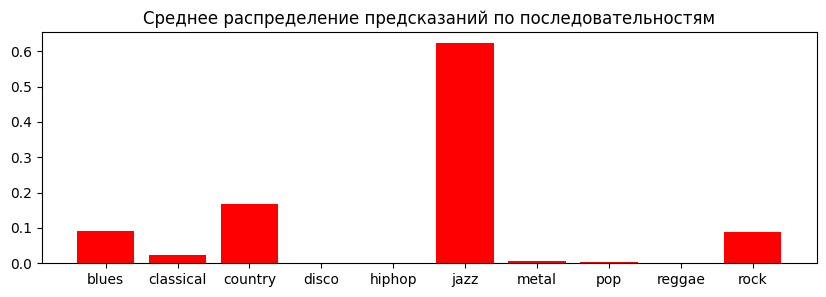

---------------------------------------------------------------
Файл: ./genres/classical/classical.00090.au
Количество последовательностей для предсказания: 28
Классификация сети: classical - ВЕРНО :-)


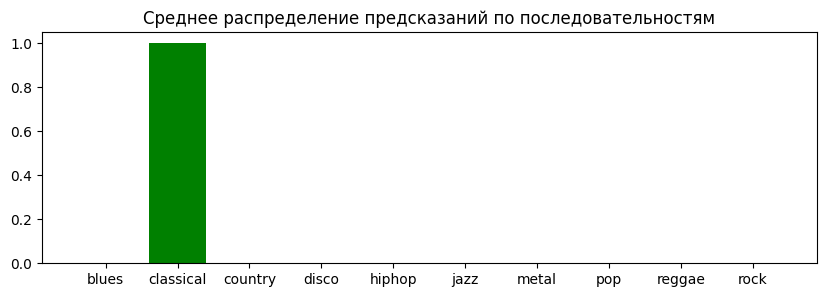

---------------------------------------------------------------
Файл: ./genres/classical/classical.00091.au
Количество последовательностей для предсказания: 28
Классификация сети: classical - ВЕРНО :-)


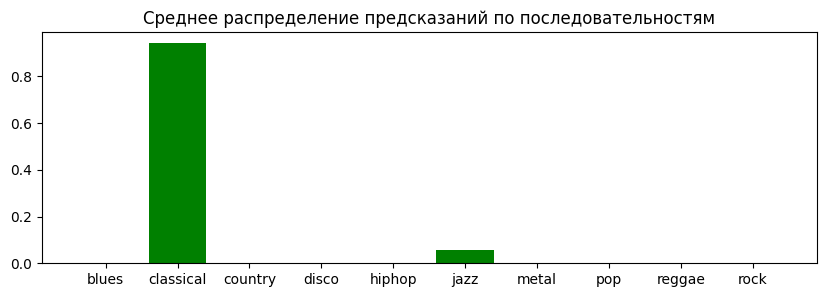

---------------------------------------------------------------
Файл: ./genres/classical/classical.00092.au
Количество последовательностей для предсказания: 28
Классификация сети: blues - НЕВЕРНО.


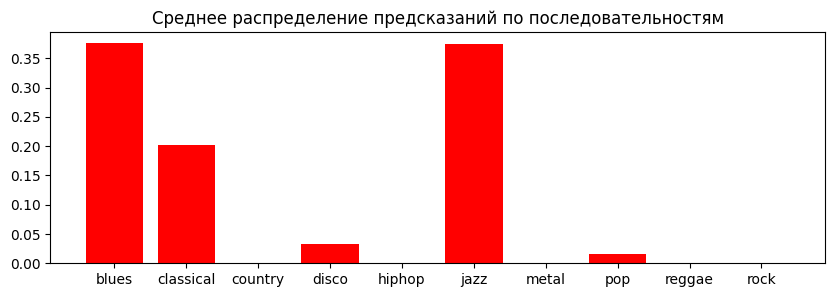

---------------------------------------------------------------
Файл: ./genres/classical/classical.00093.au
Количество последовательностей для предсказания: 28
Классификация сети: classical - ВЕРНО :-)


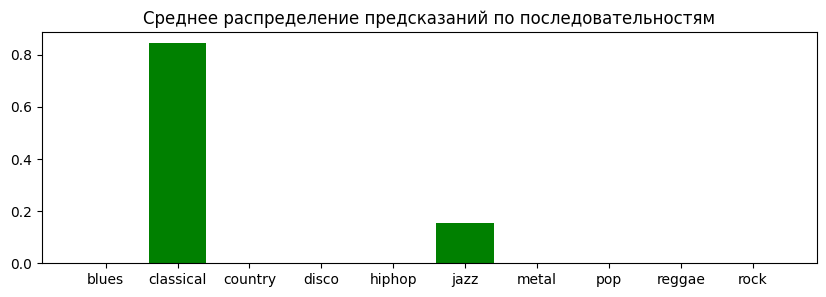

---------------------------------------------------------------
Файл: ./genres/classical/classical.00094.au
Количество последовательностей для предсказания: 28
Классификация сети: classical - ВЕРНО :-)


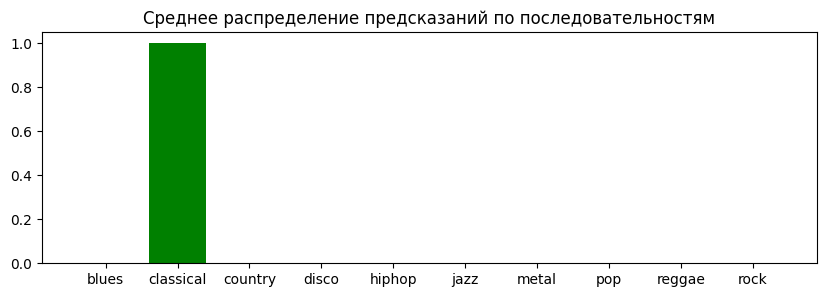

---------------------------------------------------------------
Файл: ./genres/classical/classical.00095.au
Количество последовательностей для предсказания: 28
Классификация сети: classical - ВЕРНО :-)


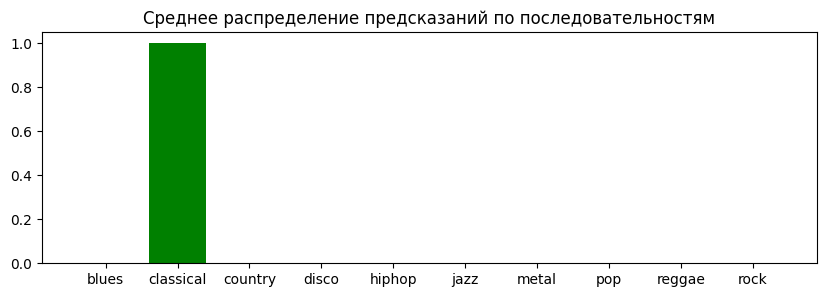

---------------------------------------------------------------
Файл: ./genres/classical/classical.00096.au
Количество последовательностей для предсказания: 28
Классификация сети: classical - ВЕРНО :-)


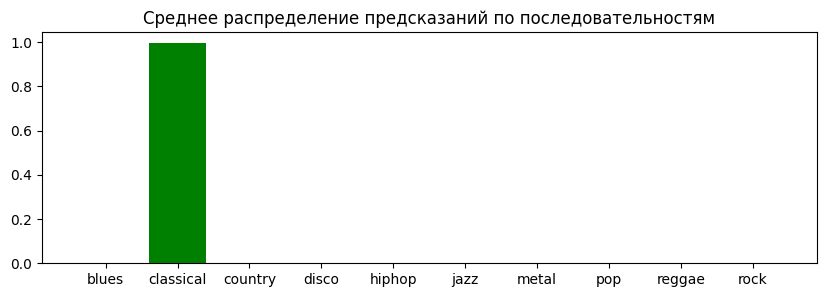

---------------------------------------------------------------
Файл: ./genres/classical/classical.00097.au
Количество последовательностей для предсказания: 28
Классификация сети: classical - ВЕРНО :-)


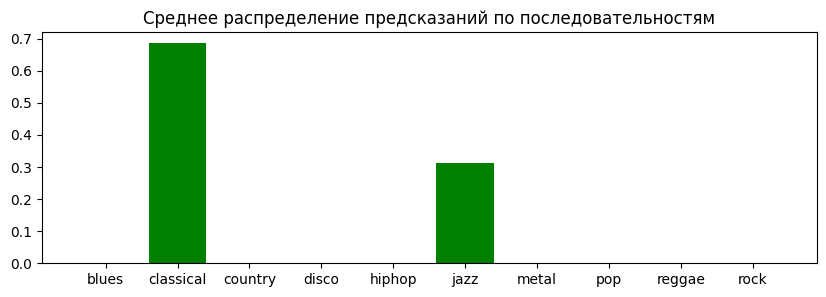

---------------------------------------------------------------
Файл: ./genres/classical/classical.00098.au
Количество последовательностей для предсказания: 28
Классификация сети: classical - ВЕРНО :-)


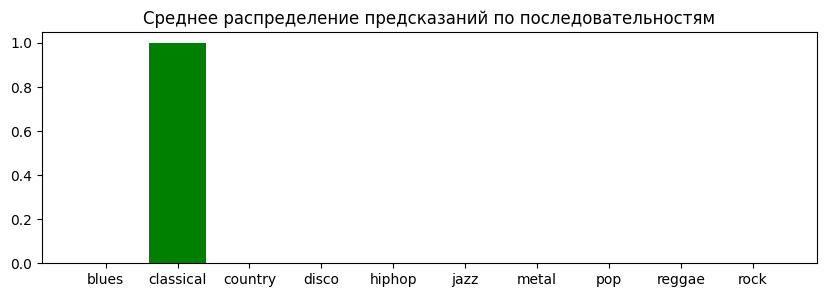

---------------------------------------------------------------
Файл: ./genres/classical/classical.00099.au
Количество последовательностей для предсказания: 28
Классификация сети: classical - ВЕРНО :-)


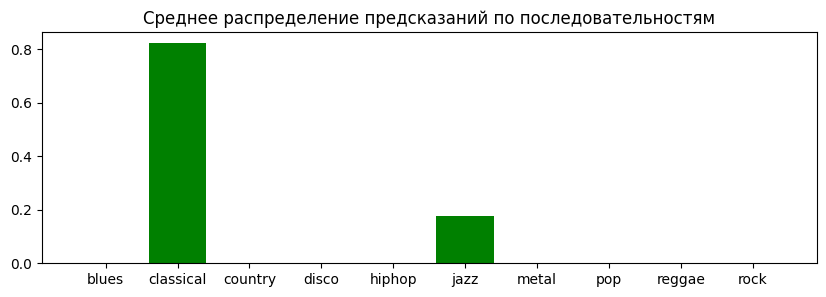

---------------------------------------------------------------
Файл: ./genres/country/country.00090.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


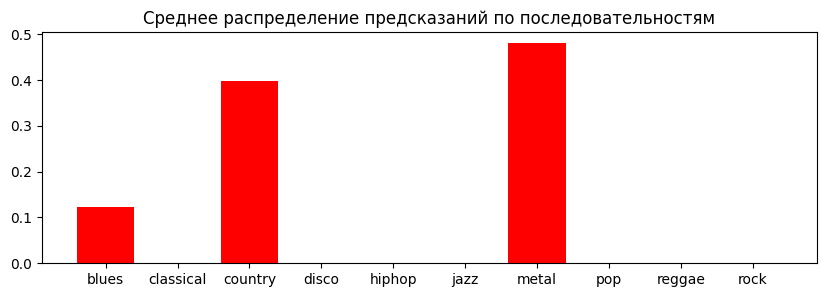

---------------------------------------------------------------
Файл: ./genres/country/country.00091.au
Количество последовательностей для предсказания: 28
Классификация сети: country - ВЕРНО :-)


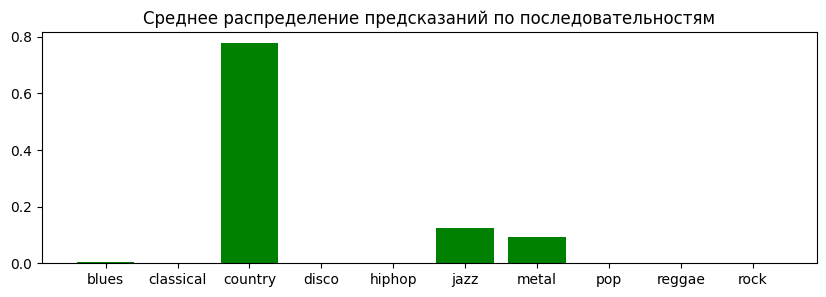

---------------------------------------------------------------
Файл: ./genres/country/country.00092.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


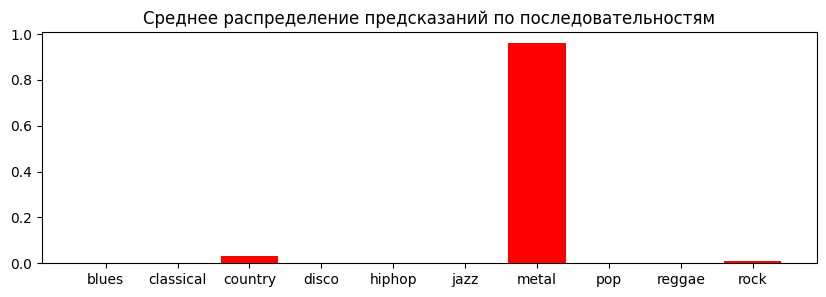

---------------------------------------------------------------
Файл: ./genres/country/country.00093.au
Количество последовательностей для предсказания: 28
Классификация сети: country - ВЕРНО :-)


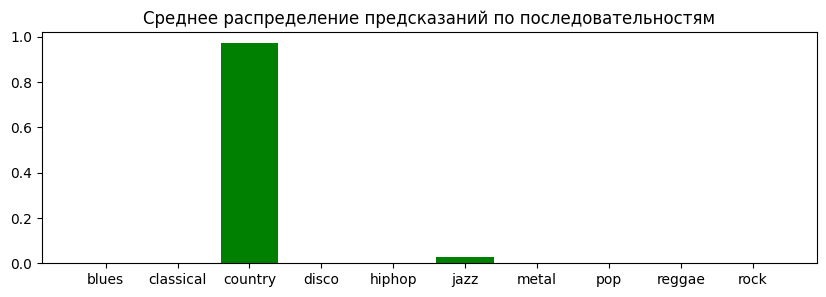

---------------------------------------------------------------
Файл: ./genres/country/country.00094.au
Количество последовательностей для предсказания: 28
Классификация сети: blues - НЕВЕРНО.


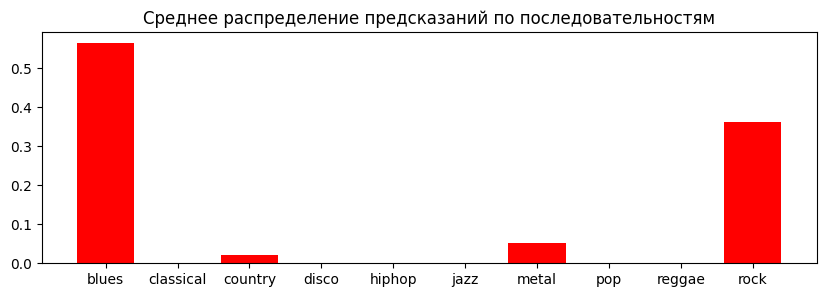

---------------------------------------------------------------
Файл: ./genres/country/country.00095.au
Количество последовательностей для предсказания: 28
Классификация сети: blues - НЕВЕРНО.


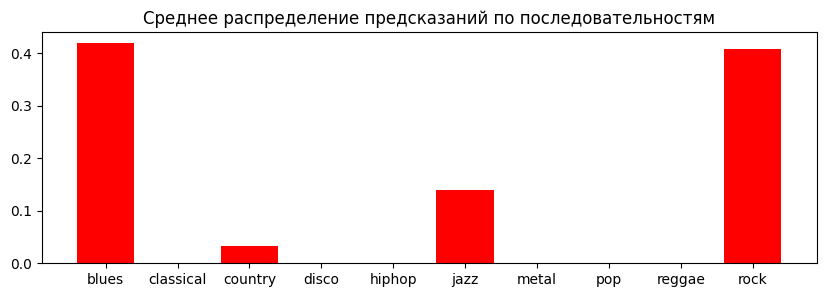

---------------------------------------------------------------
Файл: ./genres/country/country.00096.au
Количество последовательностей для предсказания: 28
Классификация сети: country - ВЕРНО :-)


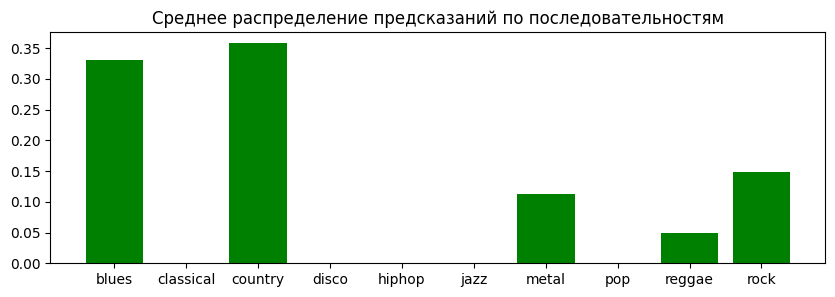

---------------------------------------------------------------
Файл: ./genres/country/country.00097.au
Количество последовательностей для предсказания: 28
Классификация сети: country - ВЕРНО :-)


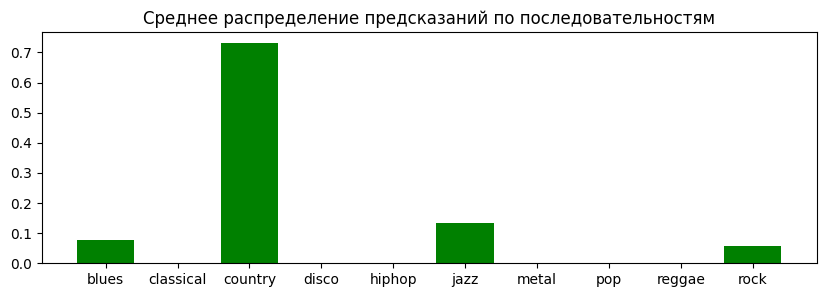

---------------------------------------------------------------
Файл: ./genres/country/country.00098.au
Количество последовательностей для предсказания: 28
Классификация сети: blues - НЕВЕРНО.


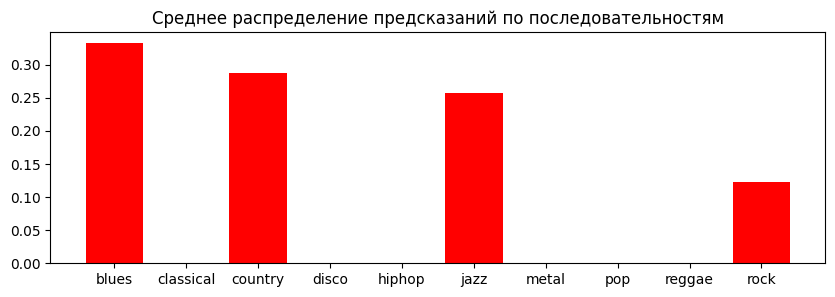

---------------------------------------------------------------
Файл: ./genres/country/country.00099.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


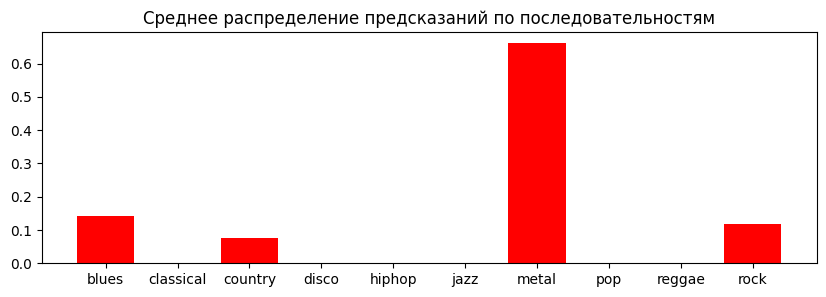

---------------------------------------------------------------
Файл: ./genres/disco/disco.00090.au
Количество последовательностей для предсказания: 28
Классификация сети: disco - ВЕРНО :-)


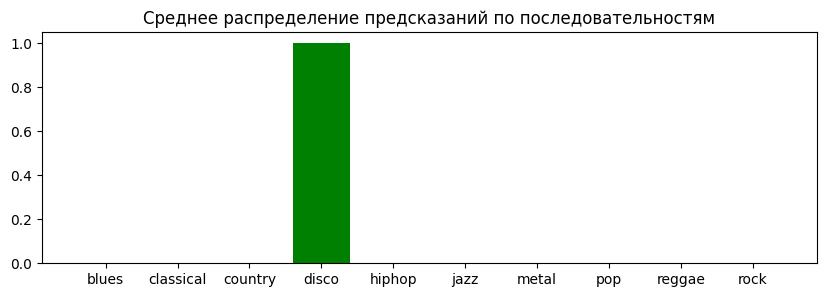

---------------------------------------------------------------
Файл: ./genres/disco/disco.00091.au
Количество последовательностей для предсказания: 28
Классификация сети: disco - ВЕРНО :-)


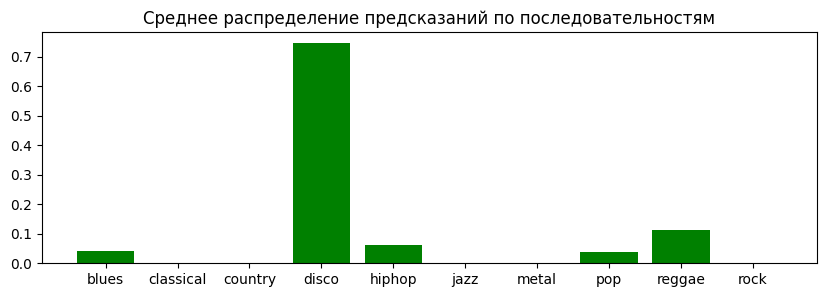

---------------------------------------------------------------
Файл: ./genres/disco/disco.00092.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


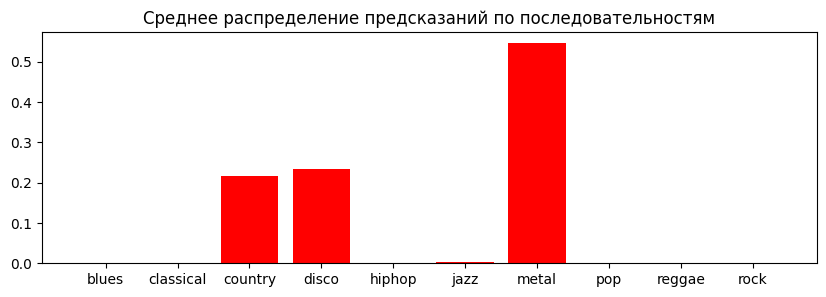

---------------------------------------------------------------
Файл: ./genres/disco/disco.00093.au
Количество последовательностей для предсказания: 28
Классификация сети: disco - ВЕРНО :-)


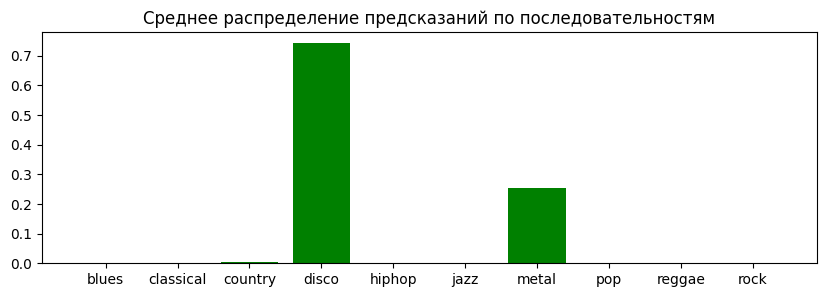

---------------------------------------------------------------
Файл: ./genres/disco/disco.00094.au
Количество последовательностей для предсказания: 28
Классификация сети: disco - ВЕРНО :-)


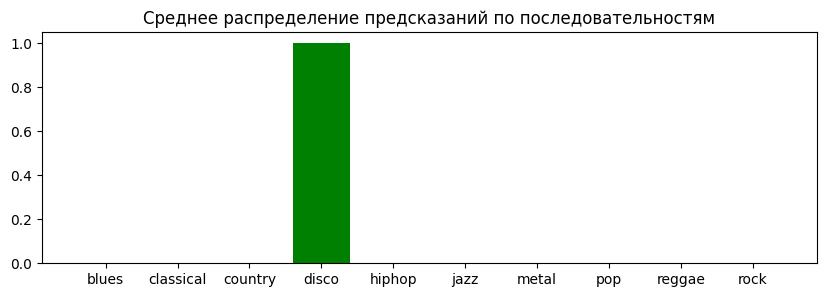

---------------------------------------------------------------
Файл: ./genres/disco/disco.00095.au
Количество последовательностей для предсказания: 28
Классификация сети: disco - ВЕРНО :-)


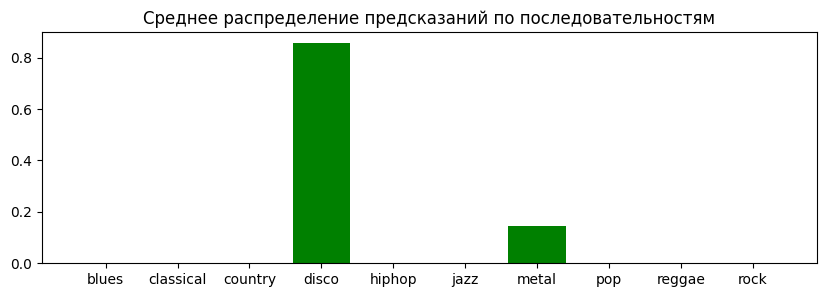

---------------------------------------------------------------
Файл: ./genres/disco/disco.00096.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


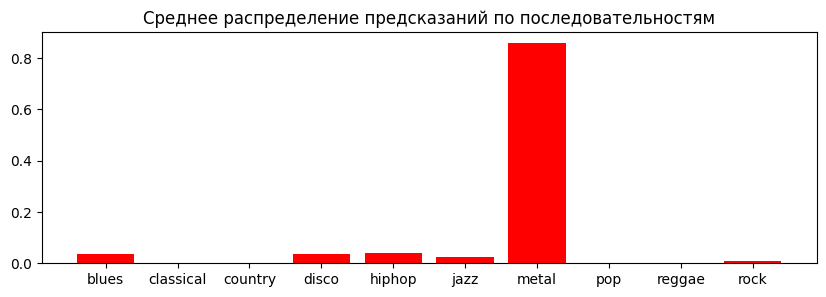

---------------------------------------------------------------
Файл: ./genres/disco/disco.00097.au
Количество последовательностей для предсказания: 28
Классификация сети: disco - ВЕРНО :-)


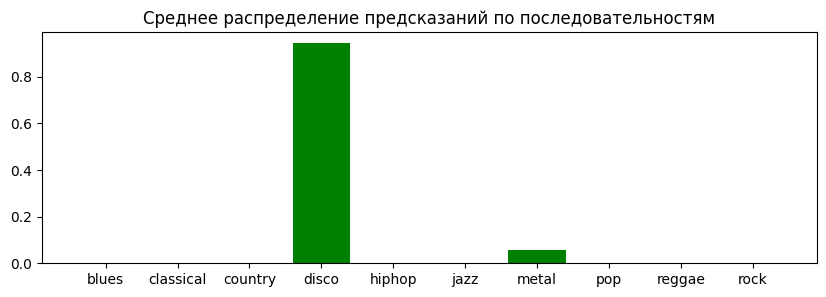

---------------------------------------------------------------
Файл: ./genres/disco/disco.00098.au
Количество последовательностей для предсказания: 28
Классификация сети: disco - ВЕРНО :-)


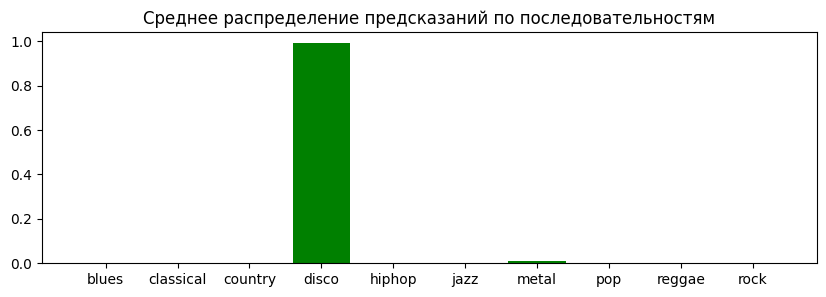

---------------------------------------------------------------
Файл: ./genres/disco/disco.00099.au
Количество последовательностей для предсказания: 28
Классификация сети: disco - ВЕРНО :-)


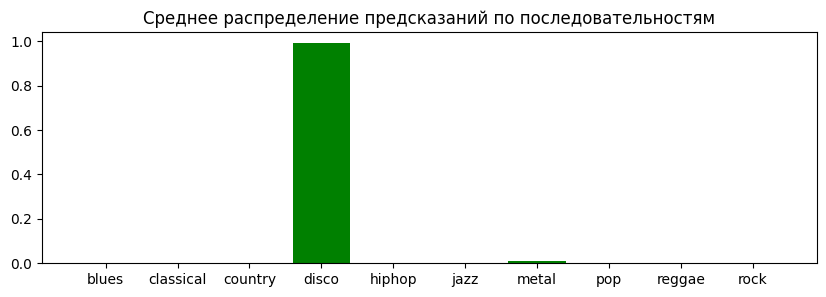

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00090.au
Количество последовательностей для предсказания: 28
Классификация сети: hiphop - ВЕРНО :-)


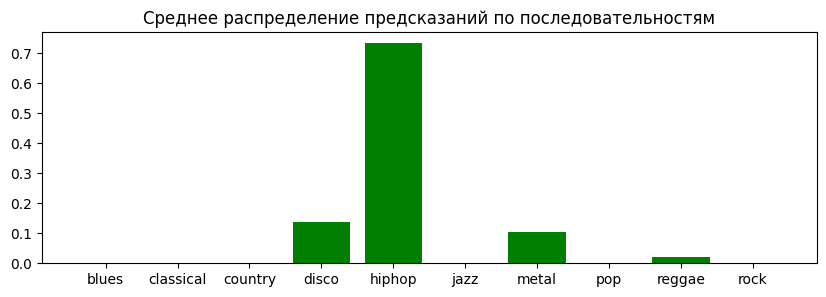

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00091.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


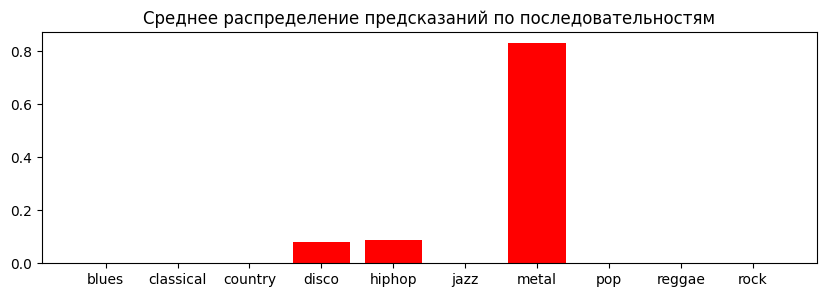

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00092.au
Количество последовательностей для предсказания: 28
Классификация сети: hiphop - ВЕРНО :-)


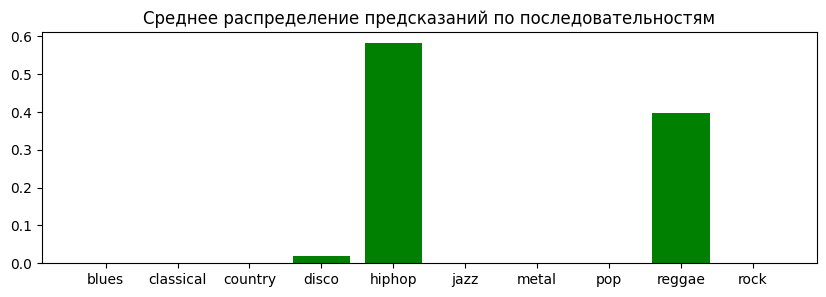

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00093.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


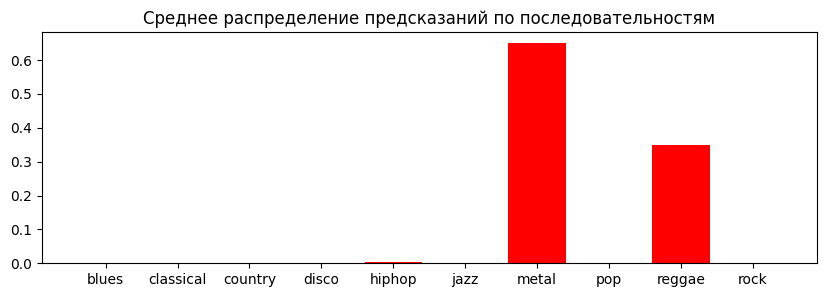

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00094.au
Количество последовательностей для предсказания: 28
Классификация сети: hiphop - ВЕРНО :-)


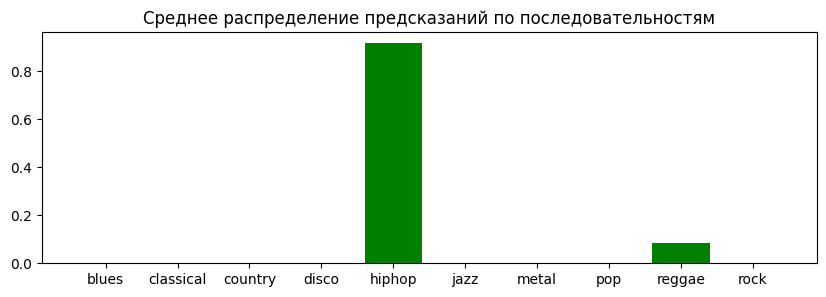

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00095.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


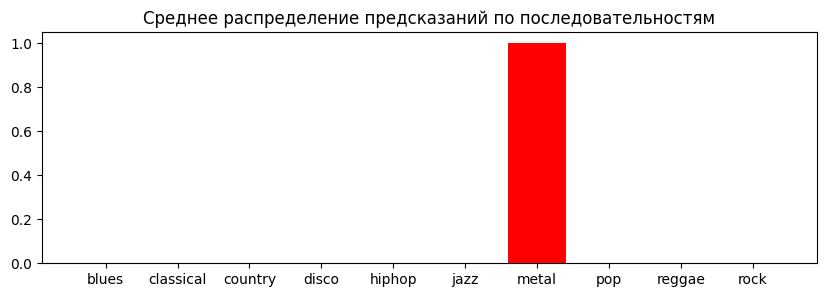

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00096.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


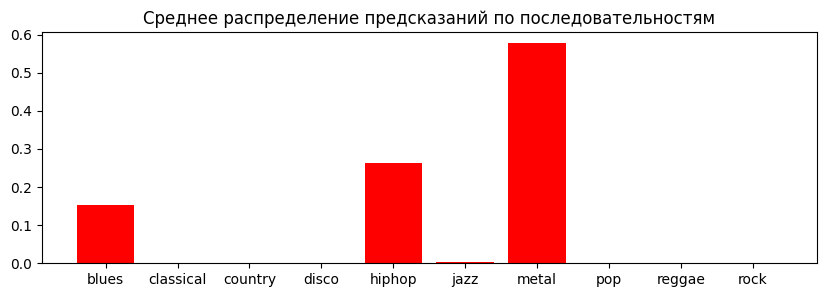

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00097.au
Количество последовательностей для предсказания: 28
Классификация сети: hiphop - ВЕРНО :-)


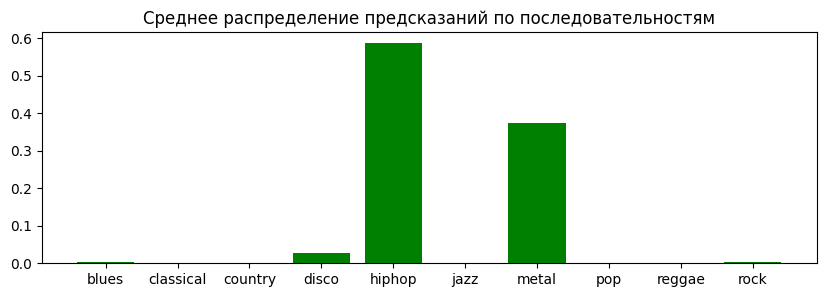

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00098.au
Количество последовательностей для предсказания: 28
Классификация сети: hiphop - ВЕРНО :-)


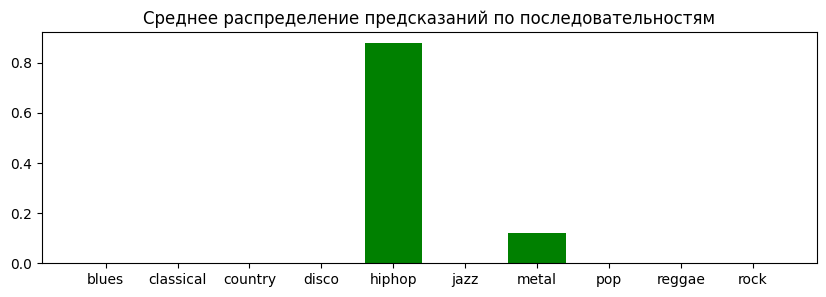

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00099.au
Количество последовательностей для предсказания: 28
Классификация сети: hiphop - ВЕРНО :-)


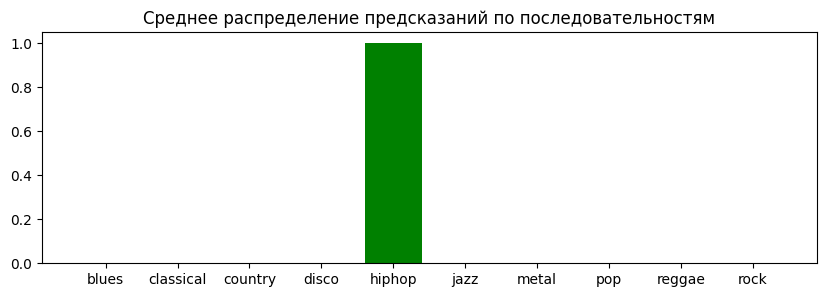

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00090.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - ВЕРНО :-)


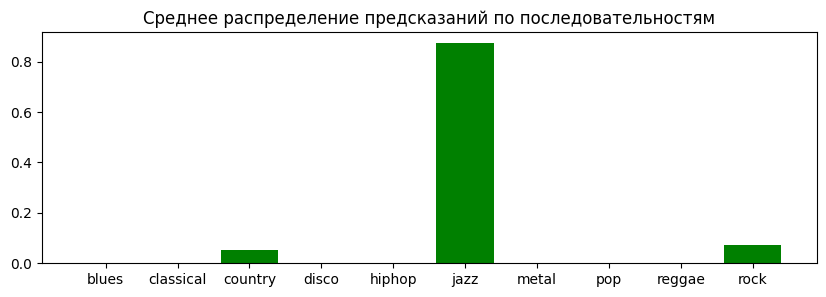

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00091.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - ВЕРНО :-)


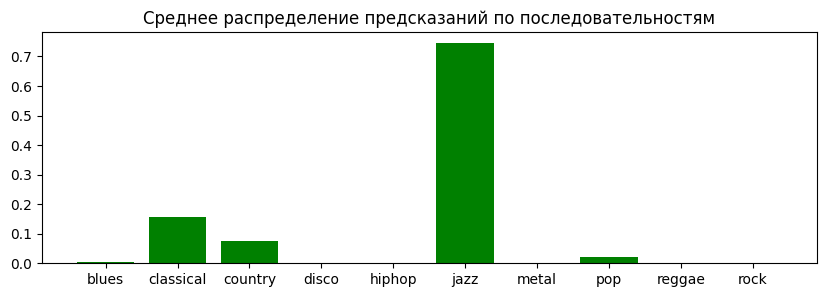

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00092.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - ВЕРНО :-)


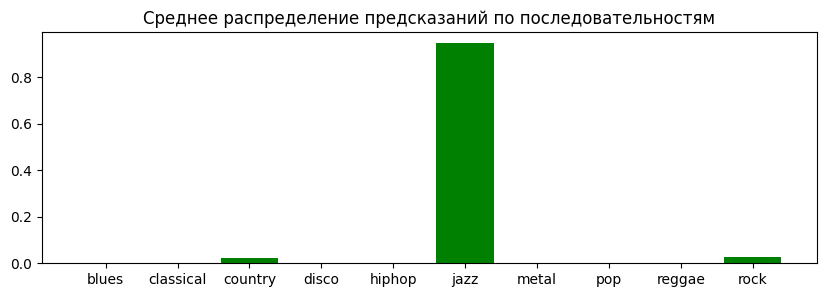

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00093.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - ВЕРНО :-)


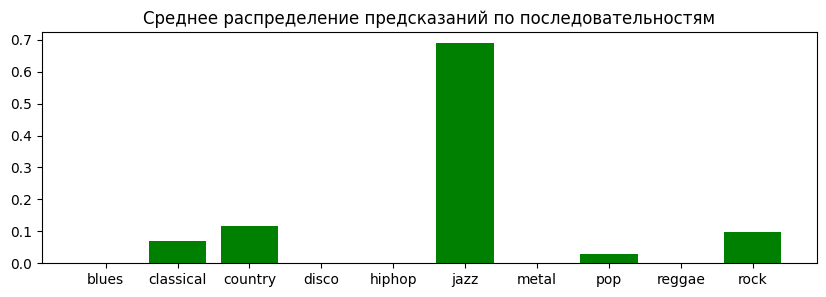

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00094.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - ВЕРНО :-)


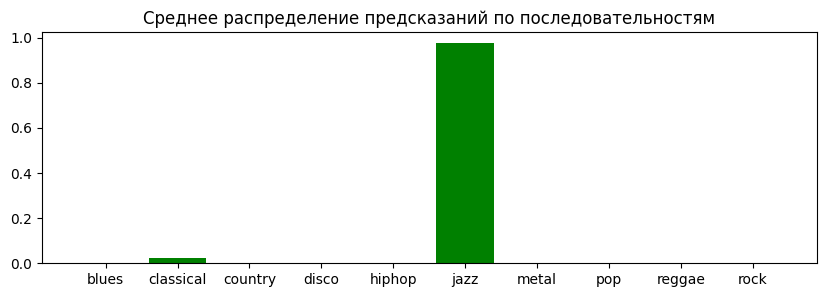

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00095.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - ВЕРНО :-)


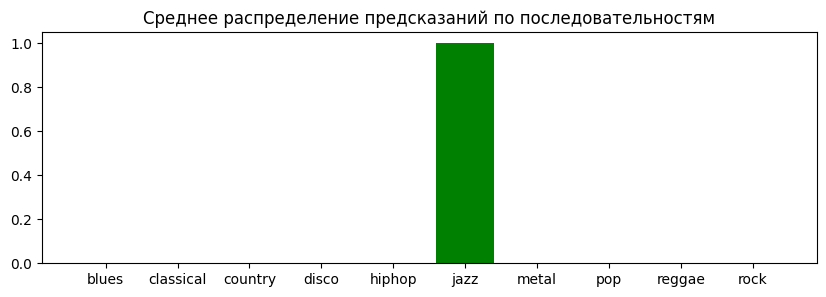

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00096.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - ВЕРНО :-)


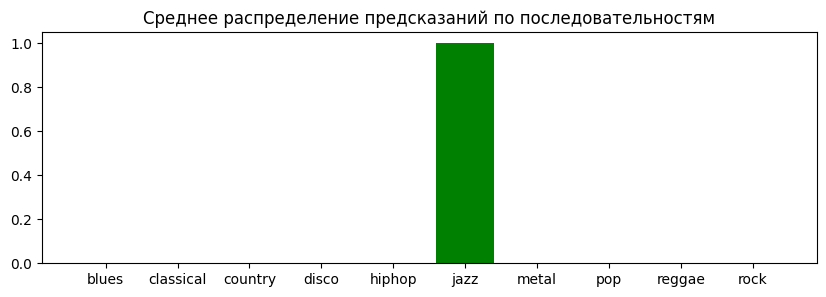

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00097.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - ВЕРНО :-)


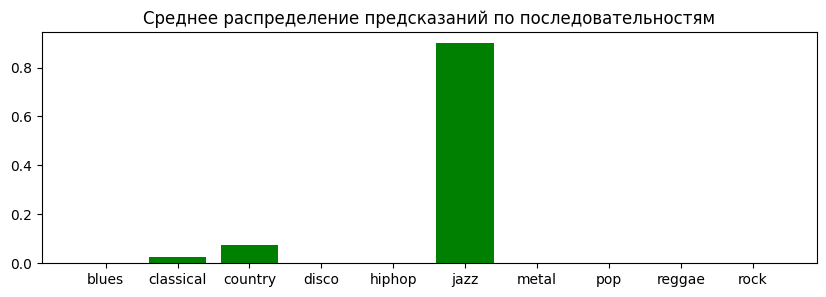

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00098.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - ВЕРНО :-)


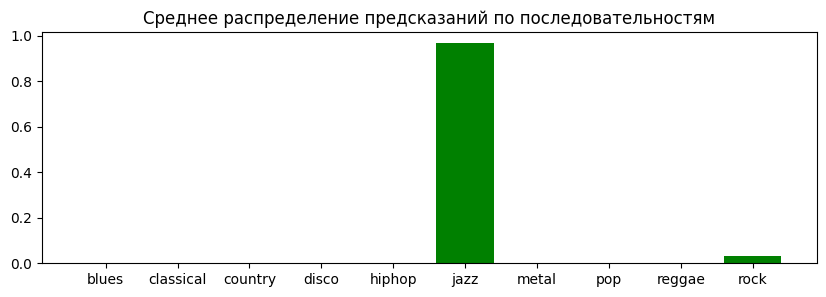

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00099.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - ВЕРНО :-)


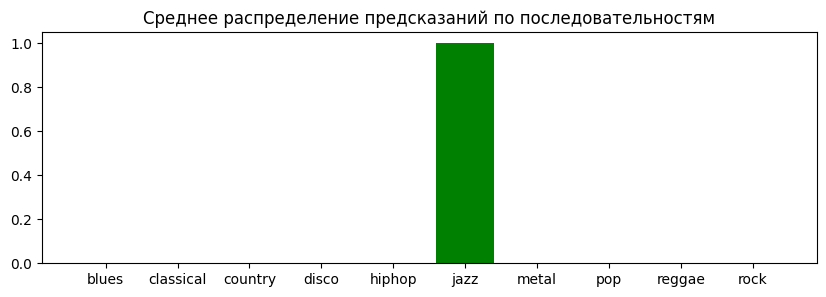

---------------------------------------------------------------
Файл: ./genres/metal/metal.00090.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - ВЕРНО :-)


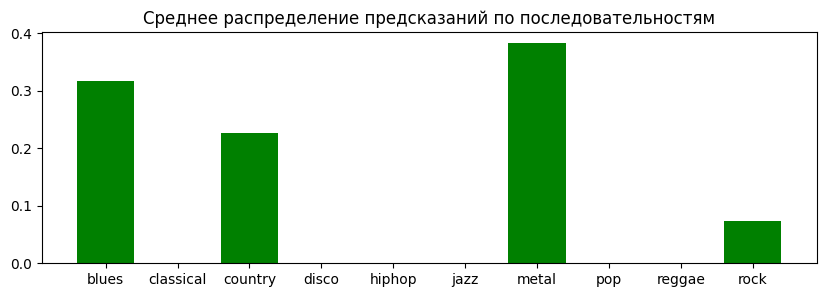

---------------------------------------------------------------
Файл: ./genres/metal/metal.00091.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - ВЕРНО :-)


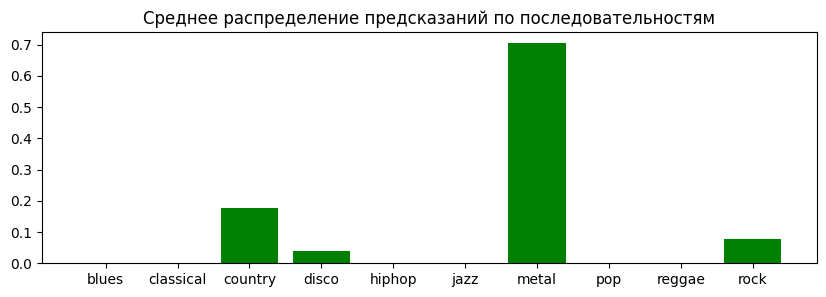

---------------------------------------------------------------
Файл: ./genres/metal/metal.00092.au
Количество последовательностей для предсказания: 28
Классификация сети: rock - НЕВЕРНО.


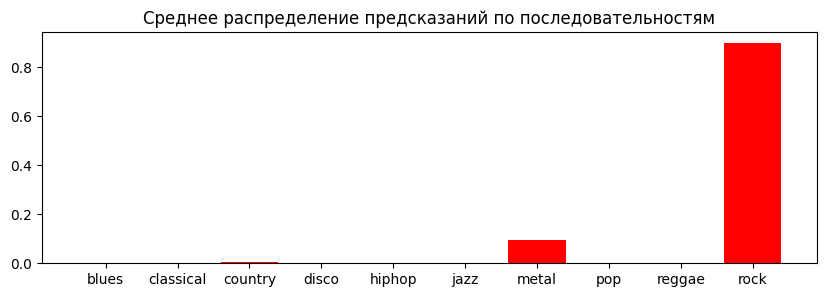

---------------------------------------------------------------
Файл: ./genres/metal/metal.00093.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - ВЕРНО :-)


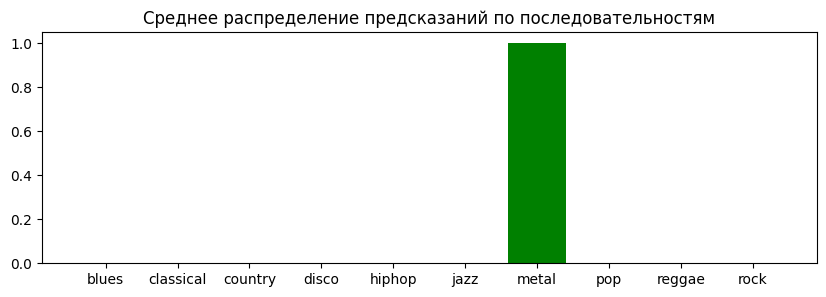

---------------------------------------------------------------
Файл: ./genres/metal/metal.00094.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - ВЕРНО :-)


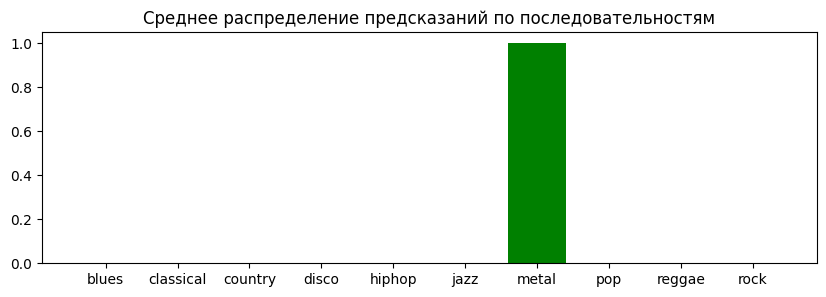

---------------------------------------------------------------
Файл: ./genres/metal/metal.00095.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - ВЕРНО :-)


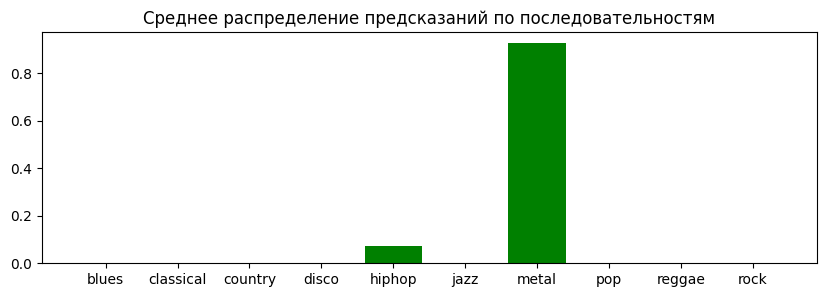

---------------------------------------------------------------
Файл: ./genres/metal/metal.00096.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - ВЕРНО :-)


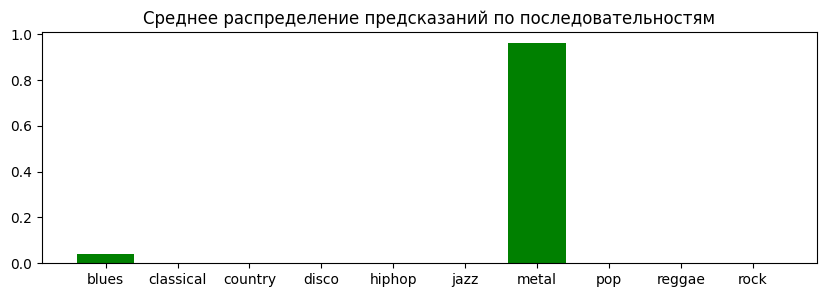

---------------------------------------------------------------
Файл: ./genres/metal/metal.00097.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - ВЕРНО :-)


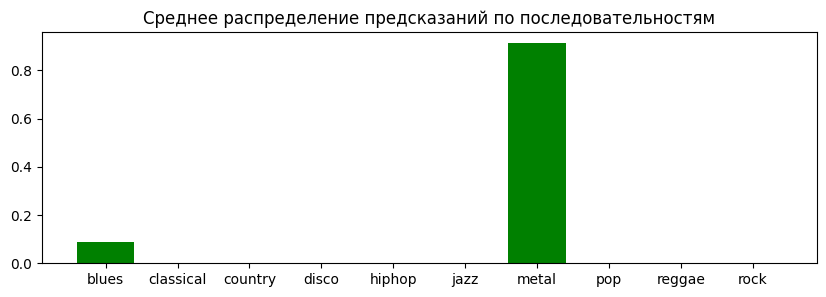

---------------------------------------------------------------
Файл: ./genres/metal/metal.00098.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - ВЕРНО :-)


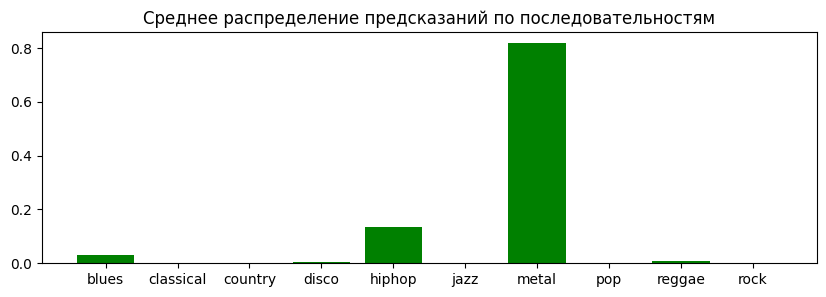

---------------------------------------------------------------
Файл: ./genres/metal/metal.00099.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - ВЕРНО :-)


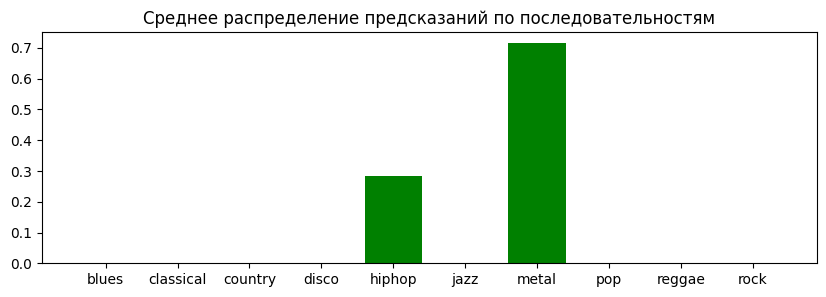

---------------------------------------------------------------
Файл: ./genres/pop/pop.00090.au
Количество последовательностей для предсказания: 28
Классификация сети: pop - ВЕРНО :-)


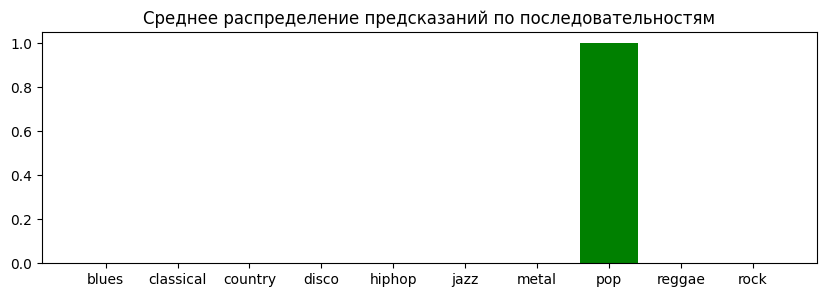

---------------------------------------------------------------
Файл: ./genres/pop/pop.00091.au
Количество последовательностей для предсказания: 28
Классификация сети: pop - ВЕРНО :-)


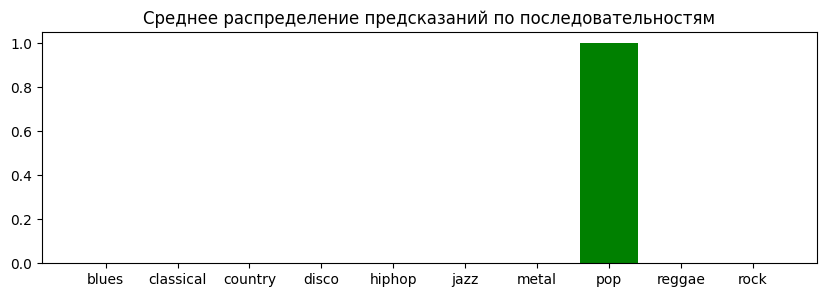

---------------------------------------------------------------
Файл: ./genres/pop/pop.00092.au
Количество последовательностей для предсказания: 28
Классификация сети: pop - ВЕРНО :-)


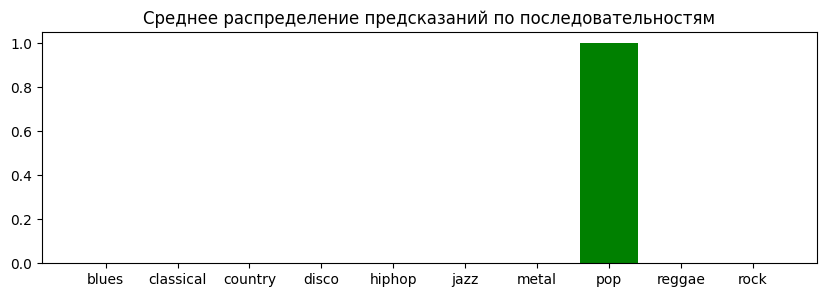

---------------------------------------------------------------
Файл: ./genres/pop/pop.00093.au
Количество последовательностей для предсказания: 28
Классификация сети: pop - ВЕРНО :-)


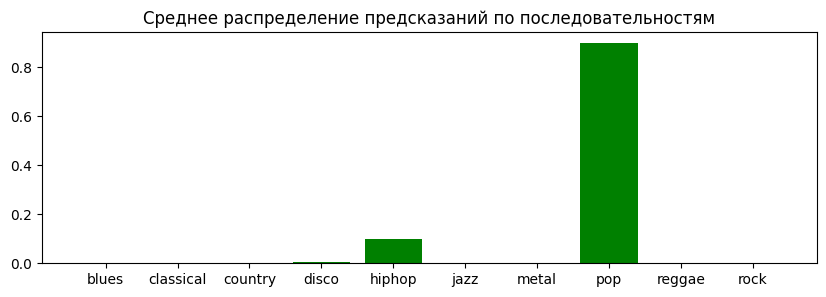

---------------------------------------------------------------
Файл: ./genres/pop/pop.00094.au
Количество последовательностей для предсказания: 28
Классификация сети: pop - ВЕРНО :-)


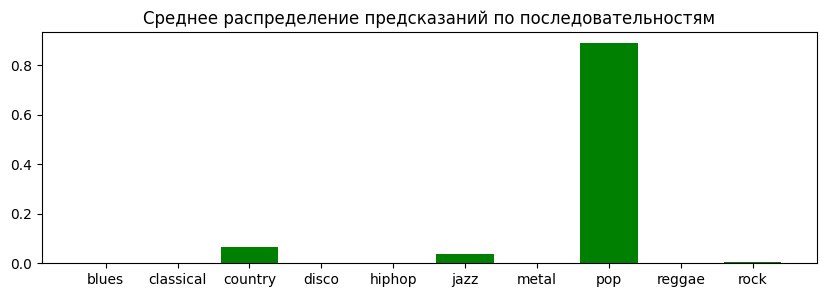

---------------------------------------------------------------
Файл: ./genres/pop/pop.00095.au
Количество последовательностей для предсказания: 28
Классификация сети: pop - ВЕРНО :-)


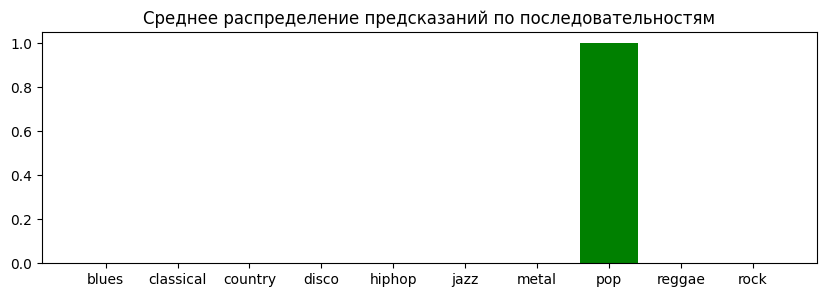

---------------------------------------------------------------
Файл: ./genres/pop/pop.00096.au
Количество последовательностей для предсказания: 28
Классификация сети: pop - ВЕРНО :-)


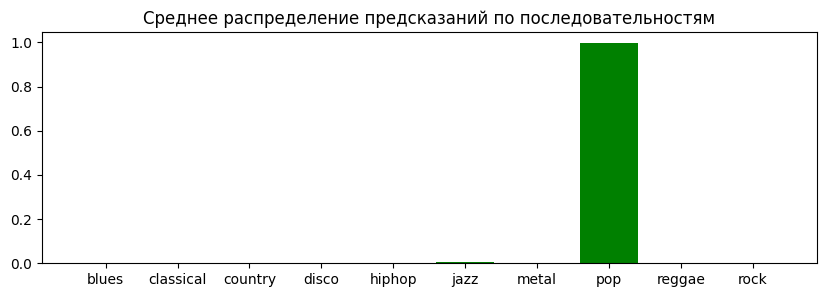

---------------------------------------------------------------
Файл: ./genres/pop/pop.00097.au
Количество последовательностей для предсказания: 28
Классификация сети: pop - ВЕРНО :-)


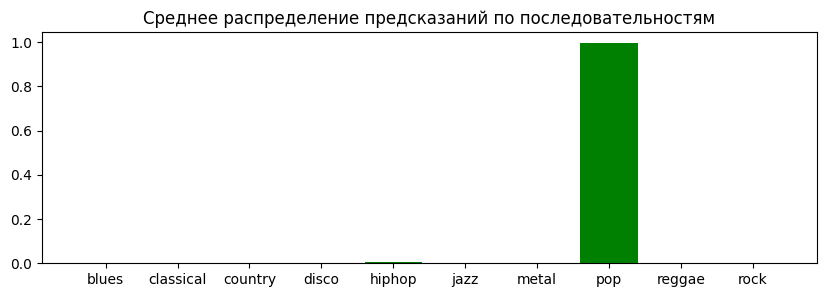

---------------------------------------------------------------
Файл: ./genres/pop/pop.00098.au
Количество последовательностей для предсказания: 28
Классификация сети: pop - ВЕРНО :-)


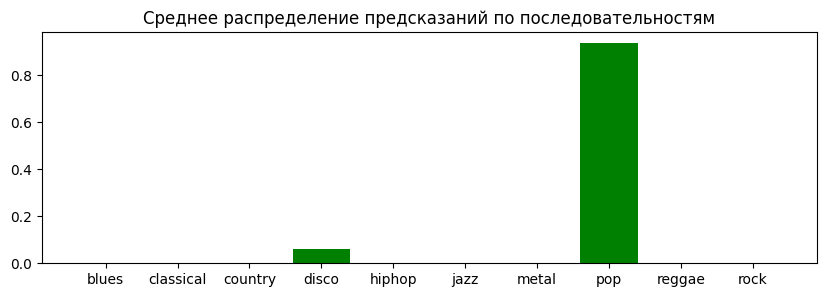

---------------------------------------------------------------
Файл: ./genres/pop/pop.00099.au
Количество последовательностей для предсказания: 28
Классификация сети: pop - ВЕРНО :-)


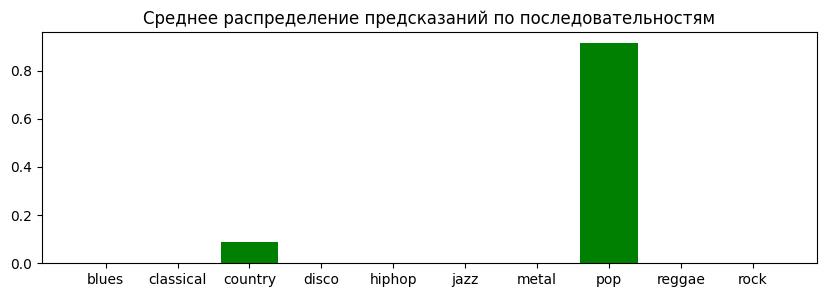

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00090.au
Количество последовательностей для предсказания: 28
Классификация сети: reggae - ВЕРНО :-)


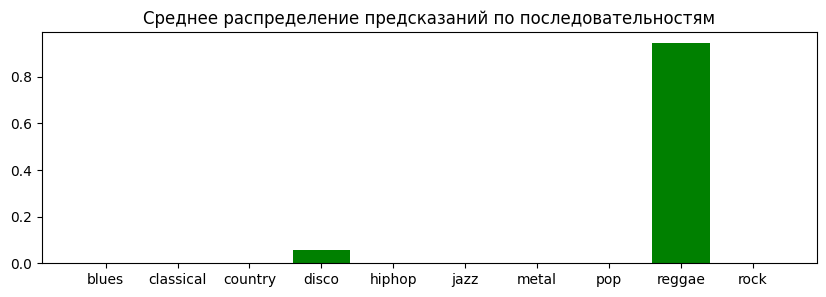

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00091.au
Количество последовательностей для предсказания: 28
Классификация сети: reggae - ВЕРНО :-)


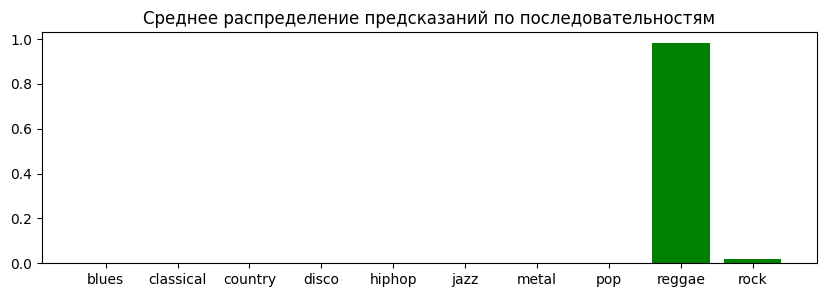

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00092.au
Количество последовательностей для предсказания: 28
Классификация сети: reggae - ВЕРНО :-)


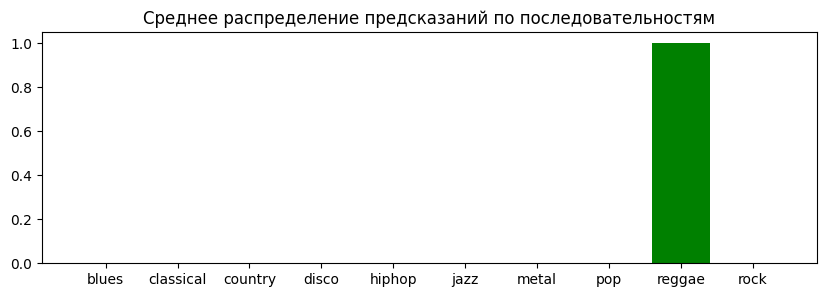

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00093.au
Количество последовательностей для предсказания: 28
Классификация сети: country - НЕВЕРНО.


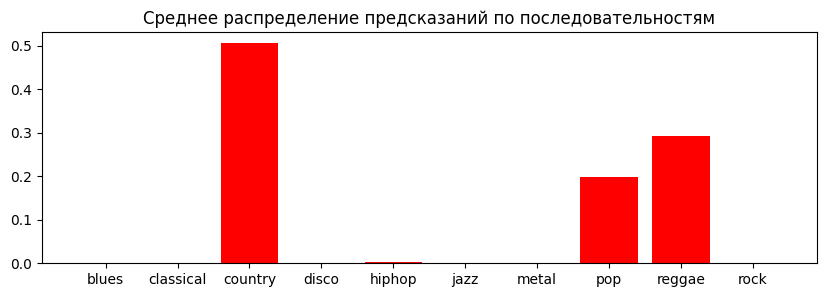

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00094.au
Количество последовательностей для предсказания: 28
Классификация сети: classical - НЕВЕРНО.


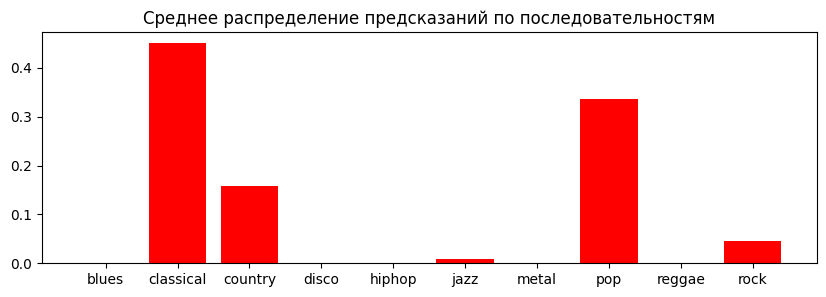

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00095.au
Количество последовательностей для предсказания: 28
Классификация сети: rock - НЕВЕРНО.


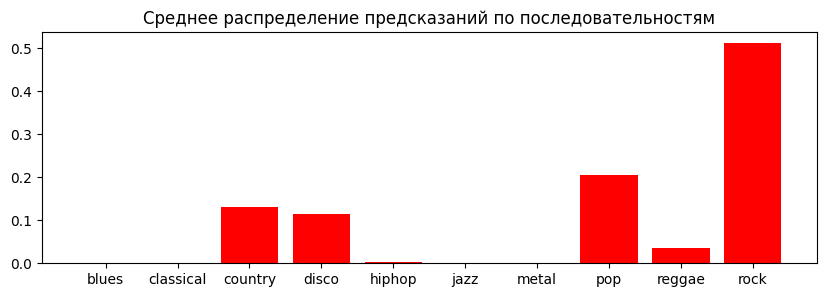

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00096.au
Количество последовательностей для предсказания: 28
Классификация сети: reggae - ВЕРНО :-)


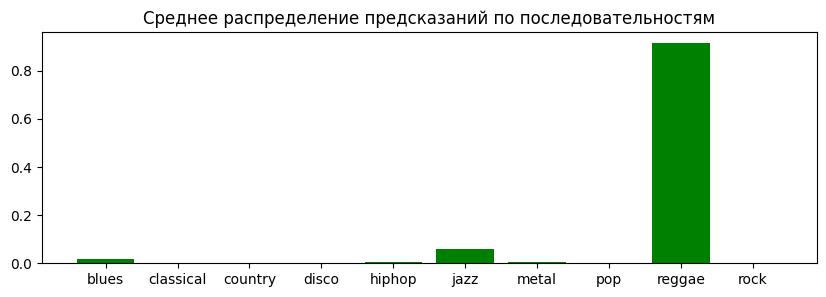

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00097.au
Количество последовательностей для предсказания: 28
Классификация сети: country - НЕВЕРНО.


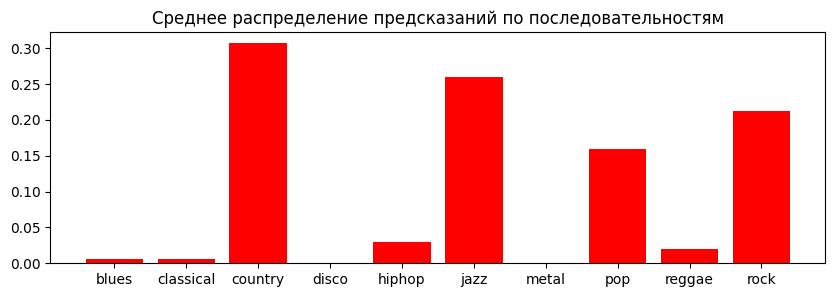

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00098.au
Количество последовательностей для предсказания: 28
Классификация сети: reggae - ВЕРНО :-)


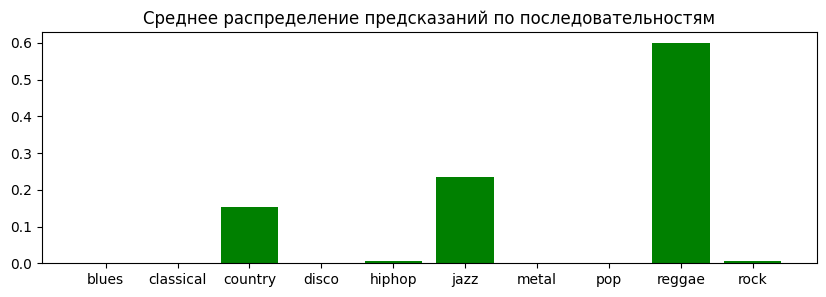

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00099.au
Количество последовательностей для предсказания: 28
Классификация сети: rock - НЕВЕРНО.


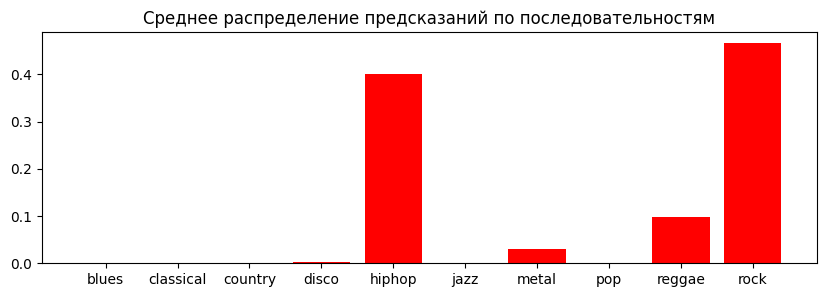

---------------------------------------------------------------
Файл: ./genres/rock/rock.00090.au
Количество последовательностей для предсказания: 28
Классификация сети: blues - НЕВЕРНО.


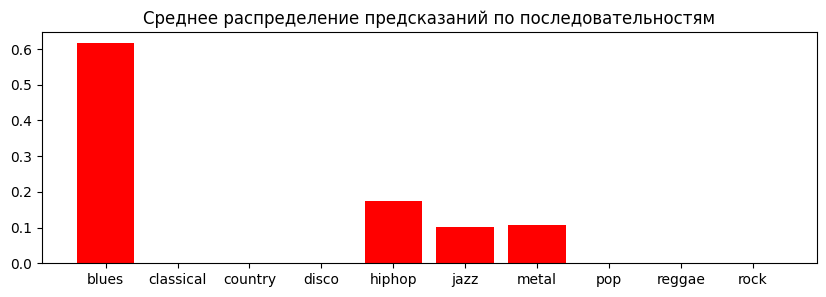

---------------------------------------------------------------
Файл: ./genres/rock/rock.00091.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


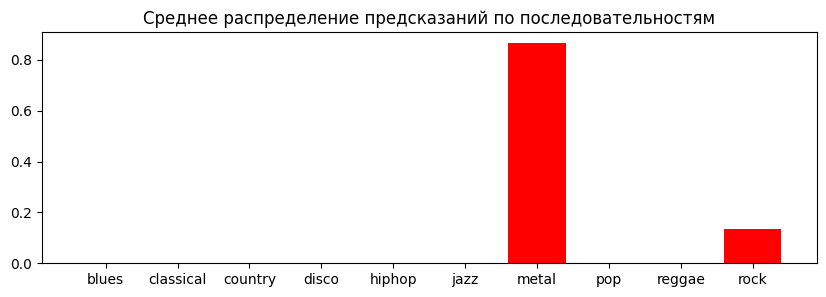

---------------------------------------------------------------
Файл: ./genres/rock/rock.00092.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


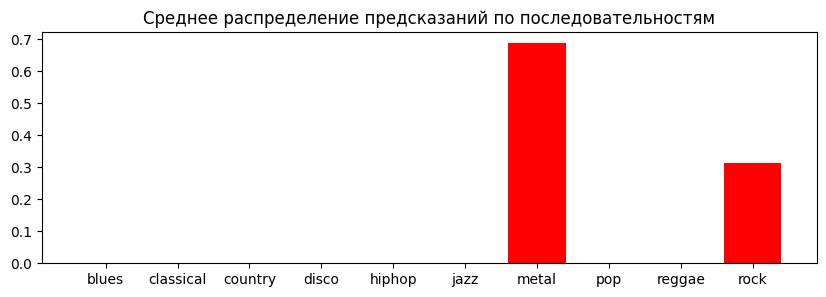

---------------------------------------------------------------
Файл: ./genres/rock/rock.00093.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - НЕВЕРНО.


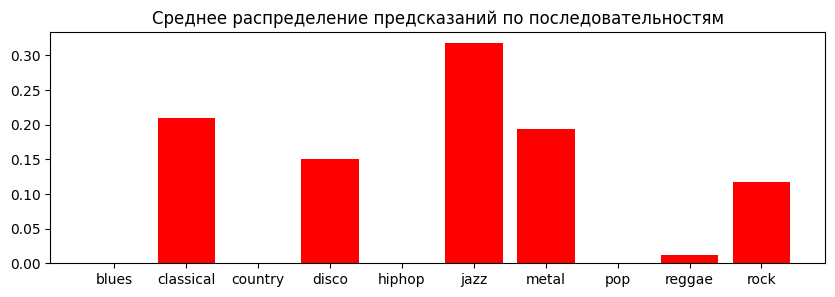

---------------------------------------------------------------
Файл: ./genres/rock/rock.00094.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


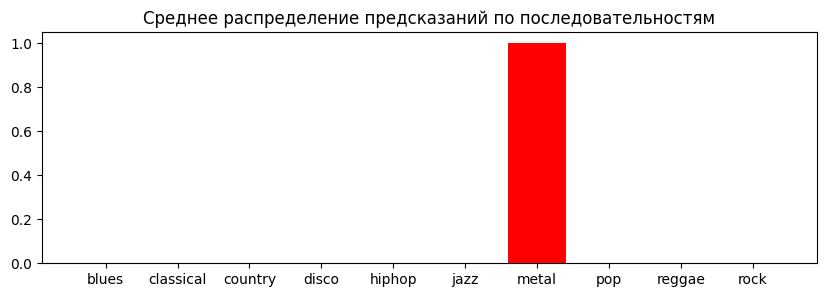

---------------------------------------------------------------
Файл: ./genres/rock/rock.00095.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


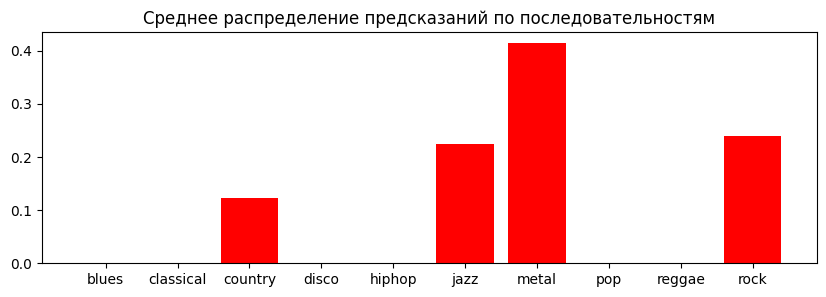

---------------------------------------------------------------
Файл: ./genres/rock/rock.00096.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


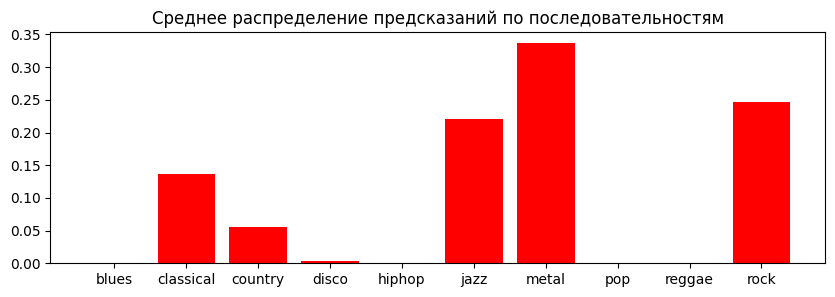

---------------------------------------------------------------
Файл: ./genres/rock/rock.00097.au
Количество последовательностей для предсказания: 28
Классификация сети: metal - НЕВЕРНО.


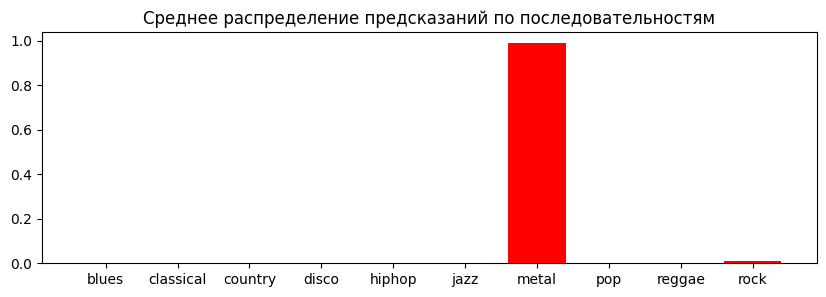

---------------------------------------------------------------
Файл: ./genres/rock/rock.00098.au
Количество последовательностей для предсказания: 28
Классификация сети: country - НЕВЕРНО.


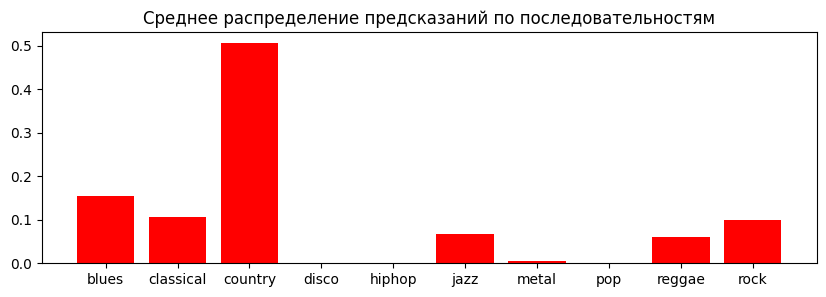

---------------------------------------------------------------
Файл: ./genres/rock/rock.00099.au
Количество последовательностей для предсказания: 28
Классификация сети: jazz - НЕВЕРНО.


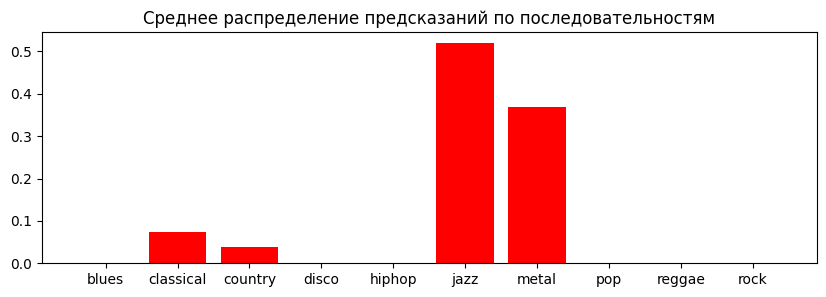

---------------------------------------------------------------
=== Обработано образцов: 100, из них распознано верно: 68, доля верных: 68.0% ===


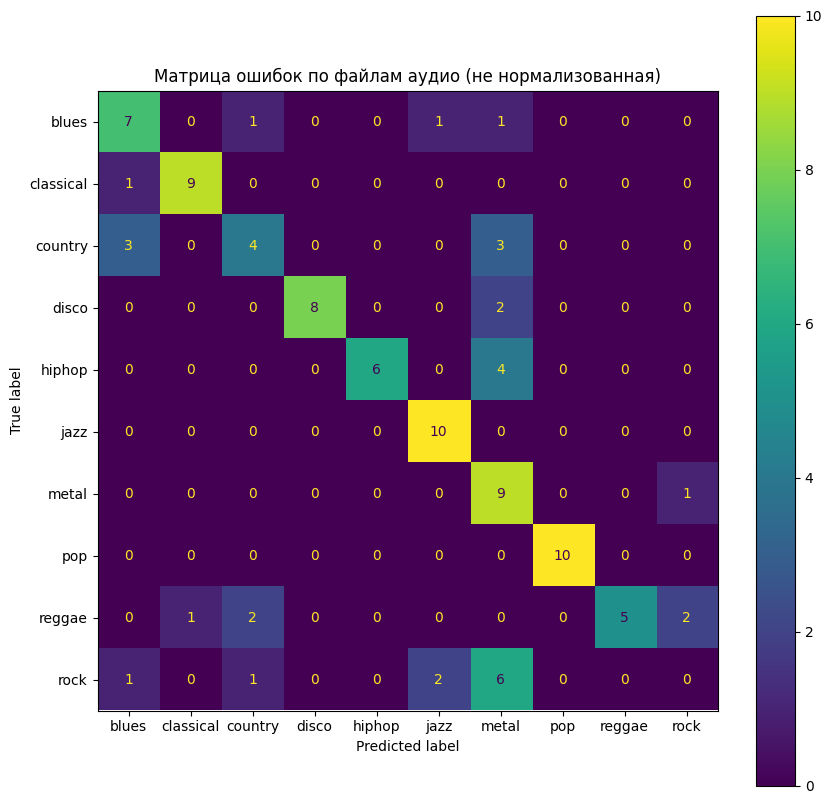

In [28]:
classify_test_files(model, x_scaler, 90, 10)